# Experimental Roman Extraction using grizli 1.5.1

## My Roman simulation
- Currently Uses Galacticus Euclid simulation 4deg2
- A modified version of aXeSIM to simulate the direct images and slitless spectra (includes fixes for WCS)

Link old slides on my Roman simulation

## Roman Parameters and Requirements
https://roman.gsfc.nasa.gov/science/technical_resources.html

#### Notes from Anahita on her Roman simulation:
- H158 filter curve: attached
- Mag limit of the simulation : 28AB magnitude (in H158)
- Exposure time : direct_image_Exptime=141sec, dispersed_image_Exptime=301sec
- Number of exposures combined: just 1 exposure with the given exptimes as above
- Number of roll angles (I would imagine we would have multiple roll angles for the HLS): We will have 4 roll angles , and 2 dithers at each roll angle. These images should be angle=0. But eventually we will produce products at roll angles=0,5,170 &175 (as suggested by Jeff Kruk and Yun)
- What are the artifacts in the direct images (CRs, diffraction spikes, bad or hot pixels)? I am not including any CRs in the direct images. Diffractions spikes are present for stars because we use PSF as the image profiles for our stars. I do not think that bad and/or hot pixels are included either (will double check).

#### Notes about the simulation

- I should just make one dispersed exposure t = 8*301 = 2408.
- Is this also true for the direct image? One exposure t=141

## Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)  
    2. [Python Helper Functions](#Python-Helper-Functions)
    3. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Find sources in the direct image](#Find-sources-in-the-direct-image)
3. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
4. [Roman object simulation](#Roman-object-simulation)
5. [Check simulation](#Check-simulation)
6. [Show direct images and slitless spectra](#Show-direct-images-and-slitless-spectra)
7. [Loop over all objects and fit their redshifts](#Loop-over-all-objects-and-fit-their-redshifts)
8. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)

Appendix
1. [Extract a single 2D spectrum](#Extract-a-single-2D-spectrum)
2. [aXeSIM predictions based on conf file](#aXeSIM-predictions-based-on-conf-file)
3. [Show 2D beam](#Show-2D-beam)
4. [Simple SN calculations based on the spcontetc](#Simple-SN-calculations-based-on-the-spcontetc)
5. [Simple SN calculations based on the pzcaletc](#Simple-SN-calculations-based-on-the-pzcaletc)
6. [Simple SN calculations based on the apttables2021](#Simple-SN-calculations-based-on-the-apttables2021)
7. [Roman Sensitivity Function](#Roman-Sensitivity-Function)
8. [1D Spectral Extraction](#1D-Spectral-Extraction)
9. [Velocity resolution](#Velocity-resolution)
10. [Fit redshift to source](#Fit-redshift-to-source)
11. [Display Redshift Fit](#Display-Redshift-Fit)
12. [Parallel Tests](#Parallel-Tests)
13. [Parallel Redshift Fitting Tests](#Parallel-Redshift-Fitting-Tests)
14. [Coordinates Check](#Coordinates-check)
15. [SED Check](#SED-check)

[top](#Table-of-Contents)

In [2]:
%matplotlib inline

In [3]:
import grizli_functions
from grizli_functions import wcs_pixel_scale, check_sims, create_circular_mask

`import jwst` failed so JWST processing will not work!



Unable to locate credentials. You can configure credentials by running "aws configure".


In [ ]:
import importlib
importlib.reload(grizli_functions)

## Import Python modules
[top](#Table-of-Contents)

In [3]:
import os, sys, time
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi
from math import sqrt, log

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table, join
from astropy.modeling import models

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep


print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
`import jwst` failed so JWST processing will not work!

 Python version:  3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]

 Grizli version:  1.6.0.dev43

 Astropy version:  5.2.1



Unable to locate credentials. You can configure credentials by running "aws configure".


In [ ]:
# check versions

# matplotlib
# IPython
# numpy
# astropy
# drizzlepac
# photutils
# grizli


## Python Helper Functions

These will eventually be replaced by grizli_functions library

In [4]:
def add_noise(hdu, scale=1.0, background=0.5, exptime=1.e4, nexp=10, readnoise=10., seed=None):

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])

    # Simple error model of read noise and sky background
    var = nexp*readnoise**2 + background*exptime

    # electrons / s
    rms = np.sqrt(var)/exptime

    poisson = hdu['ERR'].data*exptime

    hdu['ERR'].data = np.sqrt(poisson**2 + var)/exptime


    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'

    hdu['SCI'].data *= scale
    hdu['SCI'].data += np.random.normal(size=np.array(naxis).T)*rms

    return hdu

def add_noise2(hdu, background=0.5, exptime=1.e4, readnoise=10., seed=None):
    # background [e-/s]
    # readnoise [e-]

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    # N_src  # count rate from src [e-/s]
    # N_sky  # count rate from sky [e-/s]
    # N_dark # dark current
    # N_RN   # readnoise
    # t      # exposure time
    # npix   # number of pixels in aperture
    
    # signal = N_src*t
    # noise = np.sqrt(N_src*t + npix*(N_sky*t + N_dark*t + N_RN**2))
    
    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        #hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        #hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'
    
    signal = hdu['SCI'].data                                    # [e-]
    noise = np.sqrt(signal*exptime + background*exptime + readnoise**2) # [e-]
    #noise = signal + background*exptime + readnoise**2 # [e-]
    #noise = np.sqrt(background*exptime + readnoise**2)         # [e-]
    
    hdu['ERR'].data = noise/exptime # [e-/s]
    
    total_signal = np.random.poisson(lam=noise, size=noise.shape).astype("float64") # [e-]
    #total_signal = signal + noise
    final_signal = total_signal/exptime # [e-/s]

    hdu['SCI'].data = final_signal

    
    return hdu

def fake_noise(hdu, rms, exptime=1.e4):
    
    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    signal = hdu['SCI'].data # [e-] very close to the counts
    
    noise = np.random.normal(size=np.array(naxis).T)*rms # [e-/s]

    hdu['ERR'].data = noise
    hdu['SCI'].data = signal/exptime+noise
    
    return hdu

In [5]:
emlines = [["OVI",         1038.0],         # 0
           ["Ly$\\alpha$", 1215.67],        # 1
           ["CIV",     1550.0],             # 2
           ["CIII]",   1909.],              # 3
           ["CII]",    2327.],              # 4
           ["MgII",    2796.4],             # 5
           ["MgII",    2803.5],             # 6
           ["NeV",     3326.],              # 7
           ["[OII]",   3727.],  # O2        # 8
           ["[NeIII]", 3868.7],             # 9
           ["H$\gamma$",  4340.5],  # Hg    # 10
           ["[OIII]",  4363.0],  # O31      # 11
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  4959.0],  # O32      # 13
           ["[OIII]",  5007.0],  # O33      # 14
           ["[NII]",   6548.1],             # 15
           ["H$\\alpha$",  6562.8],  # Ha   # 16
           ["[NII]",   6583.0],             # 17
           ["[SII]",   6717.0],             # 18
           ["[SII]",   6731.0],             # 19
           ["P$\\delta$", 10049.8],  # Pd   # 20
           ["P$\\gamma$", 10938.0],  # Pg   # 21
           ["P$\\beta$",  12818.1],  # Pb   # 22
           ["P$\\alpha$", 18750.1],  # Pa   # 23 
           ["Br$\\delta$", 19440.0],  # Br-d (wikipedia, not exact)
           ["Br$\\gamma$", 21660.0],  # Br-g (wikipedia, not exact)
           ["Br$\\beta$",  26250.0],  # Br-b (wikipedia, not exact)
           ["Br$\\alpha$", 40510.0],  # Br-a (wikipedia, not exact) 
          ]

# http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html
# http://articles.adsabs.harvard.edu//full/1934ApJ....80...19M/0000022.000.html


## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.prep)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [ ]:
import importlib
importlib.reload(grizli.utils)

In [6]:
print(os.getcwd())

/home/gwalth/data/Roman/grizli/notebooks


## Path to my simulation directories
[top](#Table-of-Contents)

In [7]:
#os.chdir('../')
os.chdir('/Users/gwalth/data/Roman/grizli/sims/')
#os.chdir('/home/gwalth/data/Roman/grizli/sims/')
#os.chdir('/local/RomanSims/grizli/sims/') # cygnusd
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
#root = "hlss"        # multiple rolls
#root = "hlss_single"  # single roll
root = "gravlens"  # single roll

prefix = "gravlens"

HOME_PATH =  /Users/gwalth/data/Roman/grizli/sims


In [9]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
direct_files = glob.glob('*direct.fits')
#direct_files = glob.glob('*_v3_direct.fits') # shallow images
#direct_files = glob.glob('*_v4_direct.fits') # deep images
slitless_files = glob.glob('*slitless.fits')
direct_files.sort()
slitless_files.sort()
print(direct_files)
print(slitless_files)
print(len(direct_files))
print(len(slitless_files))

['gravlens_lens20_src23_v1_direct.fits']
['gravlens_lens20_src23_v1_slitless.fits']
1
1


In [10]:
hdu = pyfits.open(direct_files[0])
print(len(hdu))
print(hdu.info())
print(hdu[1].header.keys)

hdu = pyfits.open(slitless_files[0])
print(len(hdu))
print(hdu.info())
print(hdu[1].header.keys)

4
Filename: gravlens_lens20_src23_v1_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4088, 4088)   float32   
  2  ERR           1 ImageHDU        71   (4088, 4088)   float32   
  3  DQ            1 ImageHDU        35   (4088, 4088)   int32   
None
<bound method Header.keys of XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 4088 / Axis length                                    
NAXIS2  =                 4088 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Ker

In [ ]:
!ls sim_v3/Prep/roll_*/*_final.fits

In [ ]:
!ls sim_v3/Prep/roll_*/*direct_final.fits

In [ ]:
!ls sim_v3/Prep/roll_*/*slitless_final.fits

## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [ ]:
# symbolic links to the locations of the files 

# ln -s ~/aXeSIM_Roman/OUTSIM/Euclid_Roman_4deg2_field_00*_slitless.fits .
# ln -s ~/aXeSIM_Roman/OUTSIM/Euclid_Roman_4deg2_field_00*_direct.fits .
# ln -s ~/data/Roman/Galacticus/fields/Euclid_Roman_4deg2_field_????.fits .

## Updating headers for Grizli and adding "realistic" noise

Grizli looks for specific headers in order to decide with instrument conf file to use.  This also needed for how to scale the photometry and spectrocopy throughput.  

This is also useful for testing multiple conf files (which appears to be the case we are now in).

In [18]:
# testing file naming convention
#prefix = 'hlss'
grism = 'gr'
filt  = 'f158'
for i,df in enumerate(direct_files):
    #roll_ang = df.split("_")[4]
    #ndf = "-".join([prefix,"%03d.0" % float(roll_ang),filt]) + "_flt.fits"
    ndf = "-".join([prefix,filt]) + "_flt.fits"
    print(ndf)
    
    
for i,sf in enumerate(slitless_files):
    roll_ang = sf.split("_")[4]
    #nsf = "-".join([prefix,"%03d.0" % float(roll_ang),grism]) + "_flt.fits"
    nsf = "-".join([prefix,grism]) + "_flt.fits"
    print(nsf)
    

gravlens-f158_flt.fits
gravlens-gr_flt.fits


In [ ]:
# need to write something that matches headers with noise generation for exposure time

In [12]:
def add_grizli_headers(hdu, hdict, exts=[0,1,2,3]):
    
    for ext in exts:
        for key in hdict:
            hdu[ext].header[key] = hdict[key]
            
    return hdu

In [13]:
import datetime
#current_datetime = datetime.datetime.utcnow()
#print(current_datetime.isoformat())
hdu = pyfits.open(direct_files[0])
date = hdu[1].header['DATE']
#time_obj = datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')
time_obj = datetime.datetime.fromisoformat(date)
print(time_obj)
date_obs = time_obj.strftime("%Y-%m-%d")
time_obs = time_obj.strftime("%H:%M:%S")
print(date_obs)
print(time_obs)

from astropy.time import Time
t = Time(date, format='fits')
print(t.mjd)

2023-03-08 16:58:31
2023-03-08
16:58:31
60011.70730324074


In [14]:
import datetime
from astropy.time import Time

hdu = pyfits.open(direct_files[0])
exptime = hdu[0].header['EXPTIME']
crval1 = hdu[1].header['CRVAL1']
crval2 = hdu[1].header['CRVAL2']
date = hdu[1].header['DATE'] # (YYYY-MM-DDThh:mm:ss UT)

time_obj = datetime.datetime.fromisoformat(date)
date_obs = time_obj.strftime("%Y-%m-%d")
time_obs = time_obj.strftime("%H:%M:%S")

t = Time(date, format='fits')
mjd = t.mjd

#direct_dict   = {'FILTER':'H158',
direct_dict   = {'FILTER':'F158',
                 #'INSTRUME':'WFIv1-GLW',  # Pandeia's sensitivity function
                 'INSTRUME':'WFIv2-GLW',  # Anahita's sensitivity function
                 'TARGNAME':'HLSS',
                 'DATE-OBS':date_obs,
                 'TIME-OBS':time_obs, 
                 'EXPSTART':mjd, 
                 'EXPTIME':exptime,
                 'RA_TARG':crval1, 
                 'DEC_TARG':crval2, 
                 'POSTARG1':0.000000, 
                 'POSTARG2':0.000000,
                 'DETECTOR':'IR',
                 'EXTVER':1,
                 'ABZP':26.285,
                }

hdu = pyfits.open(slitless_files[0])
exptime = hdu[0].header['EXPTIME']
crval1 = hdu[1].header['CRVAL1']
crval2 = hdu[1].header['CRVAL2']
date = hdu[1].header['DATE'] # (YYYY-MM-DDThh:mm:ss UT)

time_obj = datetime.datetime.fromisoformat(date)
date_obs = time_obj.strftime("%Y-%m-%d")
time_obs = time_obj.strftime("%H:%M:%S")

t = Time(date, format='fits')
mjd = t.mjd

#slitless_dict = {'FILTER':'GRISM',
#slitless_dict = {'FILTER':'PR',
slitless_dict = {'FILTER':'GR',
                 #'INSTRUME':'WFIv1-GLW',  # Pandeia's sensitivity function
                 'INSTRUME':'WFIv2-GLW',  # Anahita's sensitivity function
                 'TARGNAME':'HLSS',
                 'DATE-OBS':date_obs ,
                 'TIME-OBS':time_obs, 
                 'EXPSTART':mjd,
                 'EXPTIME':exptime,
                 'RA_TARG':crval1, 
                 'DEC_TARG':crval2, 
                 'POSTARG1':0.000000, 
                 'POSTARG2':0.000000,
                 'DETECTOR':'IR',
                 'EXTVER':1,
                 'ABZP':26.285,
                }

print(direct_dict)
print(slitless_dict)

{'FILTER': 'F158', 'INSTRUME': 'WFIv2-GLW', 'TARGNAME': 'HLSS', 'DATE-OBS': '2023-03-08', 'TIME-OBS': '16:58:31', 'EXPSTART': 60011.70730324074, 'EXPTIME': 1128.0, 'RA_TARG': 9.1875, 'DEC_TARG': -0.3125, 'POSTARG1': 0.0, 'POSTARG2': 0.0, 'DETECTOR': 'IR', 'EXTVER': 1, 'ABZP': 26.285}
{'FILTER': 'GR', 'INSTRUME': 'WFIv2-GLW', 'TARGNAME': 'HLSS', 'DATE-OBS': '2023-03-08', 'TIME-OBS': '16:58:20', 'EXPSTART': 60011.70717592593, 'EXPTIME': 2408.0, 'RA_TARG': 9.1875, 'DEC_TARG': -0.3125, 'POSTARG1': 0.0, 'POSTARG2': 0.0, 'DETECTOR': 'IR', 'EXTVER': 1, 'ABZP': 26.285}


In [20]:
#suffix = ""
#suffix = "_final"
#suffix = "_drz_sci"

##############
### DIRECT ###
##############
for i,df in enumerate(direct_files):  

    
    hdu = pyfits.open(df)
    #print(hdu[0].header)
    #print(hdu[1].header)
    
    exptime = direct_dict['EXPTIME']
    
    #roll_ang = float(df.split("_")[4])
    #direct_dict['PA_V3'] = roll_ang
    dtime = exptime/(60.*60.*24.)
    direct_dict['EXPSTART'] += dtime*i
    hdu1 = add_grizli_headers(hdu, direct_dict)
    
    
    # Adding my noise
    #hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=141., nexp=1, readnoise=16) # single exposure
    #hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=141., nexp=1, readnoise=16) 
    hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=exptime, nexp=1, readnoise=16) 
    #hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=141, nexp=8, readnoise=16)  # full depth

    #hdu2 = add_noise2(hdu1, background=1.12, exptime=141., readnoise=16) # single exposure
    #hdu2 = add_noise2(hdu1, background=1.12, exptime=141.*8, readnoise=16) # full depth

    #hdu2 = fake_noise(hdu1, rms=0.01, exptime=141.)
    #hdu2 = fake_noise(hdu1, rms=0.001, exptime=141.)
    
    #ndf = df.replace(".fits",suffix+".fits")
    #ndf = "-".join([prefix,"%03d.0" % float(roll_ang),filt]) + "_flt.fits"
    ndf = "-".join([prefix,filt]) + "_flt.fits"

    hdu2.writeto(ndf, overwrite=True, output_verify='fix')
    print("Writing",ndf)
    

    
###############
### SPECTRA ###
###############
for i,sf in enumerate(slitless_files):    

    
    hdu = pyfits.open(sf)
    
    exptime = slitless_dict['EXPTIME']
    
    #roll_ang = float(sf.split("_")[4])
    #slitless_dict['PA_V3'] = roll_ang
    dtime = exptime/(60.*60.*24.)
    slitless_dict['EXPSTART'] += dtime*i
    hdu1 = add_grizli_headers(hdu, slitless_dict)
    
    # Adding my noise
    #hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=301., nexp=1, readnoise=16) # single exposure
    hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=exptime, nexp=1, readnoise=16) # full depth
    #hdu2 = add_noise(hdu1, scale=1.0, background=1.12, exptime=301., nexp=8, readnoise=16) # full depth

    #hdu2 = add_noise2(hdu1, background=1.12, exptime=301., readnoise=16) # single exposure
    #hdu2 = add_noise2(hdu1, background=1.12, exptime=301.*8, readnoise=16) # full depth

    #hdu2 = fake_noise(hdu1, rms=0.01, exptime=301.) # good test to detect Ha source at 
    #hdu2 = fake_noise(hdu1, rms=0.001, exptime=301.) 
    
    #nsf = sf.replace(".fits",suffix+".fits")
    #nsf = "-".join([prefix,"%03d.0" % float(roll_ang),grism]) + "_flt.fits"
    nsf = "-".join([prefix,grism]) + "_flt.fits"
    
    hdu2.writeto(nsf, overwrite=True, output_verify='fix')
    print("Writing",nsf)

Writing gravlens-f158_flt.fits
Writing gravlens-gr_flt.fits


In [21]:
#ndirect_files = glob.glob('*direct_final.fits')
#nslitless_files = glob.glob('*slitless_final.fits')
ndirect_files = glob.glob('*-f158_flt.fits')
nslitless_files = glob.glob('*-gr_flt.fits')
ndirect_files.sort()
nslitless_files.sort()
print(ndirect_files)
print(nslitless_files)
print(len(ndirect_files))
print(len(nslitless_files))

['gravlens-f158_flt.fits']
['gravlens-gr_flt.fits']
1
1


In [22]:
# two extensions

def split_fits_files_v1(file, keys=['SCI','ERR'], nkeys=['sci','wht']):
    hdu = pyfits.open(file)
    head = hdu[0].header
    
    pri_hdu = pyfits.PrimaryHDU(header=head)
        
    for k,nk in zip(keys,nkeys):    
        img = hdu[k].data
        head = hdu[k].header
        
        nfile = file.replace(".fits","_drz_" + nk + ".fits")
        
        img_hdu = pyfits.ImageHDU(img, header=head)
        new_hdu = pyfits.HDUList([pri_hdu,img_hdu])
        new_hdu.writeto(nfile, overwrite=True, output_verify='fix')
        
        print("Writing",nfile)

In [23]:
# one extension

def split_fits_files_v2(file, keys=['SCI','ERR'], nkeys=['sci','wht']):
    hdu = pyfits.open(file)
    #head = hdu[0].header
    
    
        
    for k,nk in zip(keys,nkeys):    
        img = hdu[k].data
        head = hdu[k].header

        #nfile = file.replace(".fits","_drz_" + nk + ".fits")
        nfile = file.replace("_flt.fits","_drz_" + nk + ".fits")
        
        new_hdu = pyfits.PrimaryHDU(img,header=head)
        new_hdu.writeto(nfile, overwrite=True, output_verify='fix')
        
        print("Writing",nfile)
        

def split_fits_files_v3(file, keys=['SCI','ERR'], nkeys=['sci','wht']):
    hdu = pyfits.open(file)
    #head = hdu[0].header
    
    
        
    for k,nk in zip(keys,nkeys):    
        img = hdu[k].data
        head = hdu[k].header

        nfile = file.replace(".fits","_drz_" + nk + ".fits")
        #nfile = file.replace("_flt.fits","_drz_" + nk + ".fits")
        
        new_hdu = pyfits.PrimaryHDU(img,header=head)
        new_hdu.writeto(nfile, overwrite=True, output_verify='fix')
        
        print("Writing",nfile)

In [24]:
# one file for the direct image
for i,ndf in enumerate([ndirect_files[0]]): 
    print(ndf)
    #split_fits_files_v1(ndf)
    split_fits_files_v2(ndf)

#for i,nsf in enumerate(nslitless_files):  
#    #split_fits_files_v1(nsf)
#    split_fits_files_v2(nsf)

gravlens-f158_flt.fits
Writing gravlens-f158_drz_sci.fits
Writing gravlens-f158_drz_wht.fits


In [ ]:
# one file for the direct image
split_fits_files_v3("Euclid_Roman_4deg2_field_0018_v5_direct_final.fits")


In [ ]:
import shutil

dir_file = 'hlss-018.0-f158_drz_sci.fits'
wht_file = 'hlss-018.0-f158_drz_wht.fits'
print(dir_file)
print(wht_file)

shutil.copyfile(dir_file, '%s-f158_drz_sci.fits' % (prefix))
shutil.copyfile(wht_file, '%s-f158_drz_wht.fits' % (prefix))

In [ ]:
#! cp hlss-000.0-f158_drz_sci.fits hlss-f158_drz_sci.fits
#! cp hlss-000.0-f158_drz_wht.fits hlss-f158_drz_wht.fits

In [ ]:
! cp hlss-018.0-f158_drz_sci.fits hlss-f158_drz_sci.fits
! cp hlss-018.0-f158_drz_wht.fits hlss-f158_drz_wht.fits

In [25]:
hdu = pyfits.open("%s-f158_drz_sci.fits" % (prefix))
print(len(hdu))
print(hdu.info())
#print(hdu[1].header)

1
Filename: gravlens-f158_drz_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      67   (4088, 4088)   float32   
None


In [ ]:

# not working!!!
hdu = pyfits.open("Euclid_Roman_4deg2_field_0018_v3_direct_final.fits")
print(len(hdu))
print(hdu.info())
#print(hdu[1].header)

## Roman object simulation
[top](#Table-of-Contents)

In [ ]:
##############################
# compare branch differences #
##############################

# git diff roman_sims_v1_gwalth..master -- *.py

# cd ~/python/grizli_1.3.2/grizli

# rsync -avz grismconf.py cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz model.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz multifit.py  cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli
# rsync -avz utils.py     cygnusc.ipac.caltech.edu:/home/gwalth/python/src/grizli/grizli


In [ ]:
#########################
# copy grism conf files #
#########################

# cd ~/data/Roman/grizli/grizli/CONF

# rsync -avz Roman.G150-v?-GLW.conf cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF
# rsync -avz sens_0720_2020.fits    cygnusc.ipac.caltech.edu:/home/gwalth/data/Roman/grizli/grizli/CONF

In [ ]:
import glob
#files = glob.glob("*_drz_sci.fits")
files = glob.glob("*_flt.fits")
print(files)

In [ ]:
# visists seem to be not needed, yet...

In [ ]:
visits, all_groups, info = auto_script.parse_visits(field_root=prefix, #RAW_PATH='../rolls',
                                                    files=files, combine_same_pa=False,filters=['F158','GR'])

In [ ]:
print(visits)
print(all_groups)
print(info)

In [ ]:
# Preview what will be processed

from sregion import SRegion


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

fig, ax = plt.subplots(1,1,figsize=(8,8))

for i, v in enumerate(visits):
    #sr = utils.SRegion(v['footprint'])
    sr = SRegion(v['footprint'])

    ax.scatter(*sr.centroid[0], marker='.', c=colors[i])
    
    for patch in sr.patch(ec=colors[i], fc='None', alpha=0.5, label=v['product']):
        ax.add_patch(patch)

ax.set_aspect(1./np.cos(ax.get_ylim()[0]/180*np.pi)) # square with cos(dec)
ax.set_xlim(ax.get_xlim()[::-1])
ax.legend()
ax.grid()

In [26]:
utils.set_warnings()
print(root)
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
#phot = auto_script.multiband_catalog(field_root=root, filters=['F158'], sci_image="hlss-000.0-f158_drz_sci.fits",
#                                     detection_filter='F158', get_all_filters=True)
phot = auto_script.multiband_catalog(field_root=prefix, filters=['F158'], sci_image="%s-f158_drz_sci.fits" % (prefix),
                                     detection_filter='F158', get_all_filters=True)

gravlens
# (2023-03-10 03:37:51.716)

auto_script.multiband_catalog(**{'threshold': 1.8, 'detection_background': True, 'photometry_background': True, 'get_all_filters': True, 'filters': ['F158'], 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': True, 'run_detection': True, 'detection_filter': 'F158', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 32, 'deblend_cont': 0.001}, '

In [ ]:
utils.set_warnings()
print(root)
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
phot = auto_script.multiband_catalog(field_root=root, filters=['F158'], sci_image="Euclid_Roman_4deg2_field_0018_v3_direct_final_drz_sci.fits",
                                     detection_filter='F158', get_all_filters=True)

In [32]:
#!cp hlss-F158.cat.fits hlss-ir.cat.fits
import shutil

shutil.copyfile('%s-F158.cat.fits' % (prefix), '%s-ir.cat.fits' % (prefix))

'gravlens-ir.cat.fits'

In [27]:
print(phot)
print(phot.colnames)

 id       thresh       npix ... flag_aper_6       bkg_aper_6      mask_aper_6
                            ...                      uJy                     
--- ------------------ ---- ... ----------- --------------------- -----------
  1 0.0612543448805809  703 ...           0 -0.011266604810849228         0.0
['id', 'thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2_image', 'y2_image', 'xy_image', 'errx2', 'erry2', 'errxy', 'a_image', 'b_image', 'theta_image', 'cxx_image', 'cyy_image', 'cxy_image', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag', 'x_image', 'y_image', 'number', 'ra', 'dec', 'x_world', 'y_world', 'flux_iso', 'fluxerr_iso', 'area_iso', 'mag_iso', 'kron_radius', 'kron_rcirc', 'flux_auto', 'fluxerr_auto', 'bkg_auto', 'flag_auto', 'area_auto', 'flux_radius_flag', 'flux_radius_20', 'flux_radius', 'flux_radius_90', 'tot_corr', 'mag_auto', 'magerr_auto', 'flux_aper_0', 'fluxerr_aper_0', 'flag_aper_0', 'bkg_aper_0', 'mask_ap

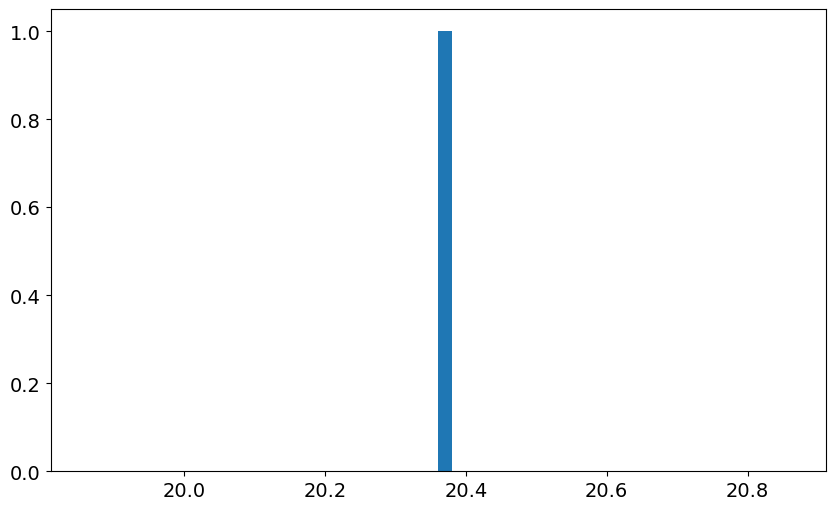

In [28]:
fig = plt.figure()
p1 = fig.add_subplot(111)
p1.hist(phot['mag_auto'],bins=50)
plt.show()


In [29]:
from grizli.pipeline.auto_script import get_yml_parameters

# Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()
print(list(kwargs.keys()))

['HOME_PATH', 'RAW_PATH', 'PREP_PATH', 'PERSIST_PATH', 'EXTRACT_PATH', 'filters', 'fetch_files_args', 'inspect_ramps', 'is_dash', 'run_prepare_dash', 'run_parse_visits', 'is_parallel_field', 'parse_visits_args', 'manual_alignment', 'manual_alignment_args', 'preprocess_args', 'visit_prep_args', 'redo_persistence_mask', 'persistence_args', 'run_fine_alignment', 'fine_backup', 'fine_alignment_args', 'make_mosaics', 'mosaic_args', 'mosaic_drizzle_args', 'mask_spikes', 'mosaic_driz_cr_type', 'make_phot', 'multiband_catalog_args', 'only_preprocess', 'overwrite_fit_params', 'grism_prep_args', 'refine_with_fits', 'run_extractions', 'include_photometry_in_fit', 'make_thumbnails', 'thumb_rgb_params', 'drizzler_args', 'thumbnail_args', 'extract_args']



Unable to locate credentials. You can configure credentials by running "aws configure".


In [30]:
print(kwargs['grism_prep_args'])

{'gris_ref_filters': {'G102': ['F105W', 'F098M', 'F110W', 'F125W', 'F140W', 'F160W', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G141': ['ir', 'F140W', 'F160W', 'F125W', 'F105W', 'F110W', 'F098M', 'F127M', 'F139M', 'F153M', 'F132N', 'F130N', 'F128N', 'F126N', 'F164N', 'F167N'], 'G800L': ['opt', 'ir', 'F814W', 'F850LP', 'F606W', 'F435W', 'F775W']}, 'files': None, 'grisms_to_process': None, 'split_by_grism': True, 'prelim_mag_limit': 25, 'refine_niter': 3, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'refine_mag_limits': [18, 24], 'ds9': None, 'mask_mosaic_edges': True}


### Using groups for multiple roll angles (testing)

In [ ]:
import importlib
importlib.reload(grizli.prep)

In [ ]:
import importlib
importlib.reload(grizli.utils)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [33]:
from importlib import reload
from grizli import model, multifit, grismconf

#os.chdir(os.path.join(HOME_PATH + root, 'Prep'))
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
         
if not os.path.exists('../Extractions'):
    os.mkdir('../Extractions')
    
files = glob.glob('*GrismFLT.fits')

if len(files) == 0:
    ### Grism contamination model

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args = kwargs['grism_prep_args']
   
    files = glob.glob("*_flt.fits")
    grism_prep_args['files'] = files
    
    # For now, turn off refining contamination model with polynomial fits
    #grism_prep_args['refine_niter'] = 2
    grism_prep_args['refine_niter'] = 0
    
    # Flat-flambda spectra
    grism_prep_args['init_coeffs'] = [1.0]
    
    grism_prep_args['mask_mosaic_edges'] = False
    
    # Fairly bright for speedup, these can be adjusted based on how deep the spectra/visits are
    grism_prep_args['refine_mag_limits'] = [17,24]
    grism_prep_args['prelim_mag_limit'] = 25
    
    grism_prep_args['gris_ref_filters'] = {'GR':['F158']}
    
    print(grism_prep_args)
    
    grp = auto_script.grism_prep(field_root=prefix, pad=800, **grism_prep_args)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(prefix), 
                            cpu_count=-1, sci_extn=1, pad=800)
    
else:
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(prefix), 
                            cpu_count=-1, sci_extn=1, pad=800) 

{'gris_ref_filters': {'GR': ['F158']}, 'files': ['gravlens-f158_flt.fits', 'gravlens-gr_flt.fits'], 'grisms_to_process': None, 'split_by_grism': True, 'prelim_mag_limit': 25, 'refine_niter': 0, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'refine_mag_limits': [17, 24], 'ds9': None, 'mask_mosaic_edges': False, 'init_coeffs': [1.0]}
# (2023-03-10 03:39:41.022)

auto_script.grism_prep(**{'field_root': 'gravlens', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 0, 'gris_ref_filters': {'GR': ['F158']}, 'files': ['gravlens-f158_flt.fits', 'gravlens-gr_flt.fits'], 'split_by_grism': True, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'cpu_count': 0, 'mask_mosaic_edges': False, 'prelim_mag_limit': 25, 'refine_mag_limits': [17, 24], 'init_coeffs': [1.0], 'grisms_to_process': None, 'pad': 800, 'model_kwargs': {'compute_size': True}})

auto_script.grism_prep: group = gr
auto_script.grism_prep: N = 1
auto_script.grism_prep: file 0 = gravlens-gr_flt.fits
aut

In [34]:
# all the ids in the grp (GLW)

all_ids = [id for flt in grp.FLTs for id in flt.object_dispersers]

print("Number of FLTs:")
print(len(grp.FLTs))

ids = list(set(all_ids))
ids.sort()
print("ids =")
print(ids)
print("Number of ids:")
print(len(ids))

Number of FLTs:
1
ids =
[1]
Number of ids:
1


In [35]:
sources = ids
print(sources)
print(len(sources))

[1]
1


In [55]:
import grizli_functions

In [57]:
from grizli_functions import display_grizli

In [56]:
import importlib
importlib.reload(grizli_functions)

<module 'grizli_functions' from '/Users/gwalth/python.linux/dev/grizli_functions.py'>

In [36]:
from grizli_functions import grizli_fit_all_z_niriss, grizli_fit_all_z_async_niriss
from grizli_functions import grizli_write_all_beams, grizli_fit_all_z_async_final_2

ImportError: cannot import name 'grizli_fit_all_z_async_final_2' from 'grizli_functions' (/Users/gwalth/python.linux/dev/grizli_functions.py)

In [ ]:
LOCAL_PATH = "/local/RomanSims/grizli/sims"

In [ ]:
print(HOME_PATH)
print(LOCAL_PATH)

In [ ]:
os.chdir(os.path.join(LOCAL_PATH, root, 'Extractions'))

In [37]:
os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))

In [38]:
grizli_write_all_beams(root=prefix, 
                       sources = sources)

Writing beams for 1 sources
Load gravlens-gr.01.GrismFLT.fits!
Files loaded - 0.69 sec.
Number of FLTs:
1
1
gravlens_00001.beams.fits


In [39]:
def beams_ids(root):
    """Generates list of ids from beams written
    
    Parameters
    ----------
    root: str
        Beam format 
            '{root}_{id}.beams.fits'
    
    Returns
    -------
    ids: list
    """
    
    L = glob.glob("{0}*.beams.fits".format(root))
    
    ids = []
    for l in L:
        id = int(l.replace(".beams.fits","").replace(root + "_",""))
        ids.append(id)
    return ids

#bids = beams_ids(root)
bids = beams_ids(prefix)
#print(bids)
print(len(bids))
help(beams_ids)
bids.sort()

#bids.index(595)
sources = bids
print(sources)
print(len(sources))

1
Help on function beams_ids in module __main__:

beams_ids(root)
    Generates list of ids from beams written
    
    Parameters
    ----------
    root: str
        Beam format 
            '{root}_{id}.beams.fits'
    
    Returns
    -------
    ids: list

[1]
1


In [42]:
#ind = sources.index(1453)
#print(ind)

#new_sources = sources[:500]
#new_sources = sources[1500:2000]
new_sources = sources

#new_sources = sources[ind:]
print(new_sources)
print(len(new_sources))

[1]
1


In [40]:
print(HOME_PATH)
#print(LOCAL_PATH)
print(root)
print(prefix)

/Users/gwalth/data/Roman/grizli/sims
gravlens
gravlens


In [ ]:
import importlib
importlib.reload(grizli.multifit)

1
load_master_fits: gravlens_00001.beams.fits
1 gravlens-gr_flt.fits GR
User templates! N=16 

  0.0500   19438.9 (0.0500) 1/475
  0.0542   19441.8 (0.0500) 2/475
  0.0584   19438.5 (0.0584) 3/475
  0.0627   19450.4 (0.0584) 4/475
  0.0669   19442.7 (0.0584) 5/475
  0.0712   19444.9 (0.0584) 6/475
  0.0755   19446.8 (0.0584) 7/475
  0.0798   19450.2 (0.0584) 8/475
  0.0841   19450.8 (0.0584) 9/475
  0.0885   19440.6 (0.0584) 10/475
  0.0929   19442.2 (0.0584) 11/475
  0.0972   19443.4 (0.0584) 12/475
  0.1016   19438.1 (0.1016) 13/475
  0.1060   19432.4 (0.1060) 14/475
  0.1105   19428.8 (0.1105) 15/475
  0.1149   19425.5 (0.1149) 16/475
  0.1194   19436.7 (0.1149) 17/475
  0.1239   19252.8 (0.1239) 18/475
  0.1284   19278.5 (0.1239) 19/475
  0.1329   19410.6 (0.1239) 20/475
  0.1375   19422.1 (0.1239) 21/475
  0.1420   19424.7 (0.1239) 22/475
  0.1466   19417.3 (0.1239) 23/475
  0.1512   19410.6 (0.1239) 24/475
  0.1558   19398.3 (0.1239) 25/475
  0.1604   19403.4 (0.1239) 26/475
  0.

  1.2542   19464.2 (1.2007) 192/475
  1.2632   19490.1 (1.2007) 193/475
  1.2723   19468.9 (1.2007) 194/475
  1.2814   19422.4 (1.2007) 195/475
  1.2905   19392.8 (1.2007) 196/475
  1.2997   19365.2 (1.2007) 197/475
  1.3089   19358.3 (1.2007) 198/475
  1.3182   19354.9 (1.2007) 199/475
  1.3275   19372.1 (1.2007) 200/475
  1.3368   19390.3 (1.2007) 201/475
  1.3462   19401.9 (1.2007) 202/475
  1.3556   19399.8 (1.2007) 203/475
  1.3650   19407.6 (1.2007) 204/475
  1.3745   19405.5 (1.2007) 205/475
  1.3840   19403.5 (1.2007) 206/475
  1.3936   19398.7 (1.2007) 207/475
  1.4032   19401.7 (1.2007) 208/475
  1.4128   19380.0 (1.2007) 209/475
  1.4225   19392.9 (1.2007) 210/475
  1.4322   19388.8 (1.2007) 211/475
  1.4419   19400.2 (1.2007) 212/475
  1.4517   19416.2 (1.2007) 213/475
  1.4615   19437.9 (1.2007) 214/475
  1.4714   19435.7 (1.2007) 215/475
  1.4813   19441.1 (1.2007) 216/475
  1.4913   19435.1 (1.2007) 217/475
  1.5012   19435.6 (1.2007) 218/475
  1.5113   19434.7 (1.2007) 

  3.8008   20131.1 (1.2007) 381/475
  3.8201   20040.9 (1.2007) 382/475
  3.8394   20016.3 (1.2007) 383/475
  3.8588   19949.5 (1.2007) 384/475
  3.8783   19926.1 (1.2007) 385/475
  3.8978   19906.9 (1.2007) 386/475
  3.9175   19858.6 (1.2007) 387/475
  3.9372   19818.5 (1.2007) 388/475
  3.9569   19801.0 (1.2007) 389/475
  3.9768   19739.8 (1.2007) 390/475
  3.9968   19701.2 (1.2007) 391/475
  4.0168   19672.9 (1.2007) 392/475
  4.0369   19638.1 (1.2007) 393/475
  4.0571   19612.0 (1.2007) 394/475
  4.0774   19572.4 (1.2007) 395/475
  4.0977   19555.2 (1.2007) 396/475
  4.1181   19527.1 (1.2007) 397/475
  4.1386   19490.3 (1.2007) 398/475
  4.1592   19357.1 (1.2007) 399/475
  4.1799   19504.1 (1.2007) 400/475
  4.2007   19492.0 (1.2007) 401/475
  4.2215   19491.5 (1.2007) 402/475
  4.2425   19509.0 (1.2007) 403/475
  4.2635   19508.6 (1.2007) 404/475
  4.2846   19495.4 (1.2007) 405/475
  4.3057   19495.1 (1.2007) 406/475
  4.3270   19492.1 (1.2007) 407/475
  4.3484   19500.9 (1.2007) 

  1.1937   19227.0 (1.1937) 19/41
  1.1959   19124.9 (1.1959) 20/41
  1.1980   19061.3 (1.1980) 21/41
  1.2002   19090.5 (1.1980) 22/41
  1.2024   19167.1 (1.1980) 23/41
  1.2047   19241.2 (1.1980) 24/41
  1.2069   19317.3 (1.1980) 25/41
  1.2091   19370.7 (1.1980) 26/41
  1.2113   19391.9 (1.1980) 27/41
  1.2135   19410.1 (1.1980) 28/41
  1.2157   19423.0 (1.1980) 29/41
  1.2179   19425.0 (1.1980) 30/41
  1.2201   19425.7 (1.1980) 31/41
  1.2224   19427.0 (1.1980) 32/41
  1.2246   19425.5 (1.1980) 33/41
  1.2268   19424.5 (1.1980) 34/41
  1.2290   19425.2 (1.1980) 35/41
  1.2313   19423.7 (1.1980) 36/41
  1.2335   19421.3 (1.1980) 37/41
  1.2357   19417.4 (1.1980) 38/41
  1.2380   19413.6 (1.1980) 39/41
  1.2402   19417.8 (1.1980) 40/41
  1.2425   19423.4 (1.1980) 41/41
First iteration: z_best=1.1980

- 1.1965   19101.7 (1.1965) 1/21
- 1.1967   19094.6 (1.1967) 2/21
- 1.1969   19087.9 (1.1969) 3/21
- 1.1971   19081.7 (1.1971) 4/21
- 1.1973   19076.1 (1.1973) 5/21
- 1.1975   19071.2 (1

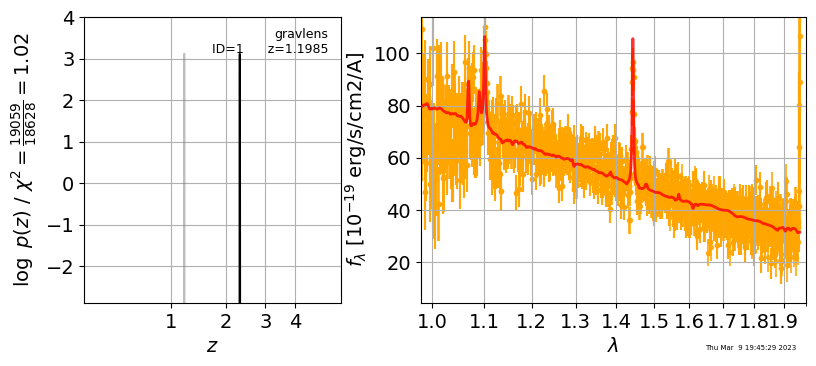

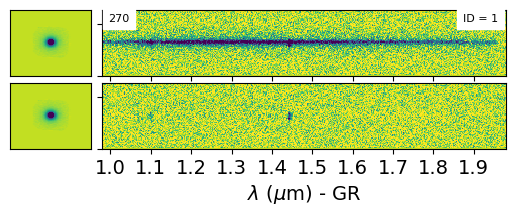

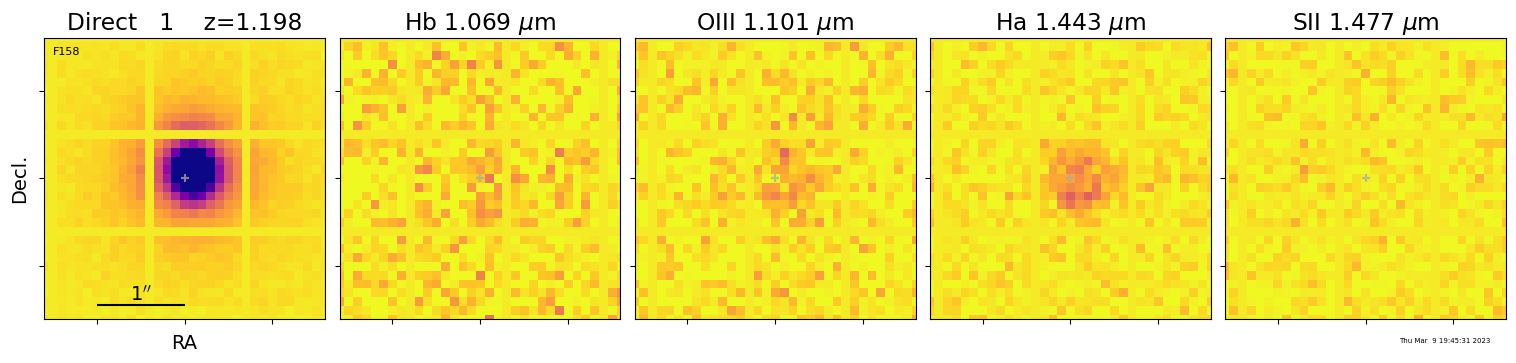

In [43]:
t0 = time.time()

fwhm = 325 # km/s
#t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
#t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
temp0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
temp1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


#for id in sources:
for id in new_sources:

    print(id)
    
    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 6.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=prefix)

    

t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
# grizli_fit_all_z_async_final_2 works with grps format!!!

### grizli_fit_all_z_async_final_2
Redshift fitting process:
1. grizli_write_all_beams
2. beams_ids
3. grizli_fit_all_z_async_final_2

To do:
- fix when there are no sources


In [ ]:
grizli_fit_all_z_async_final_2(HOME_PATH=HOME_PATH,        
                               root=root, prefix=prefix, sources = new_sources,
                               N_CPU=4, mag_limit=30, z1=0.05, z2=6.0)  


F158
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   64 / length of dimension 1                          NAXIS2  =                  947 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    8 / number of table fields                         TTYPE1  = 'wave    '                                                            TFORM1  = 'D       '                                                            TUNIT1  = 'Angstrom'                                                            TTYPE2  = 'flux    '                                                            TFORM2  = 'D       '              

{0: <Axes: xlabel='$z$', ylabel='$\\log\\ p(z)$ / $\\chi^2=\\frac{19059}{18628}=1.02$'>,
 1: <Axes: xlabel='z', ylabel='risk'>,
 2: <Axes: xlabel='$\\lambda$ (microns)', ylabel='F$_\\lambda$ (erg/s/cm$^2$/$\\AA$)'>,
 3: <Axes: xlabel='$\\lambda$ (microns)', ylabel='F$_\\lambda$ (erg/s/cm$^2$/$\\AA$)'>}

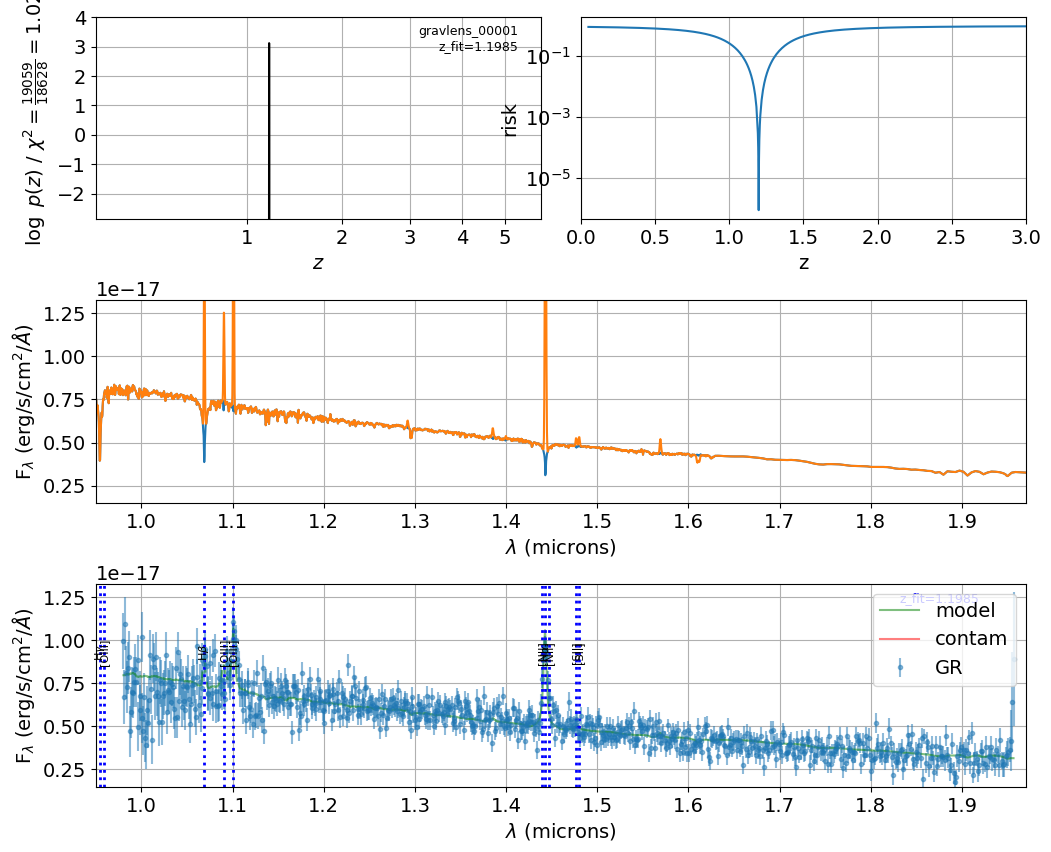

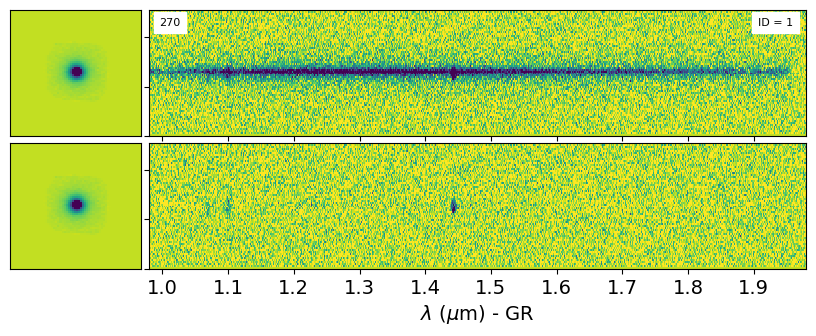

In [64]:
prefix = '{0}_{1:05d}'.format(root, id)

display_grizli(prefix,dispersers=["GR"], w0=0.95, w1=1.97, scale_size=1.6, 
               cmap='viridis_r')
               #cmap='inferno_r')

In [171]:
# Load original spectra
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

L = glob.glob("*spectra.fits")
print(L)
pf = pyfits.open(L[0])
pf.info()

exts = [ext.header['EXTNAME'] for ext in pf if 'EXTNAME' in ext.header]
print(exts)
print(pf[1].header)

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
tbl_spec = {}
for i,ext in enumerate(exts):
    tbl_spec[i] = Table(pf[ext].data)
    
    #ax1.plot(tbl_spec[i]['WAV_NM']*10,tbl_spec[i]['FLUX'])
    
#ax1.set_xlim(10000,20000)
#plt.show()  
#print(tbl[0].colnames)

['gravlens_lens20_src23_v1_spectra.fits']
Filename: gravlens_lens20_src23_v1_spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ugca_166_spec    1 TableHDU        21   2346R x 2C   [E15.7, E15.7]   
  2  ngc_4660_spec    1 TableHDU        21   3211R x 2C   [E15.7, E15.7]   
['ugca_166_spec', 'ngc_4660_spec']
XTENSION= 'TABLE   '           / ASCII table extension                          BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   30 / length of dimension 1                          NAXIS2  =                 2346 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    2 / number of table f

In [142]:
emlines = [
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  5007.0],  # O33      # 14
           ["H$\\alpha$",  6562.8],  # Ha   # 16
          ]

gravlens_00001.stack.fits
Filename: gravlens_00001.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SCI         GR,270.0 ImageHDU        45   (908, 64)   float32   
  2  WHT         GR,270.0 ImageHDU        22   (908, 64)   float32   
  3  CONTAM      GR,270.0 ImageHDU        22   (908, 64)   float32   
  4  MODEL       GR,270.0 ImageHDU        24   (908, 64)   float32   
  5  KERNEL      GR,270.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         GR  ImageHDU        44   (908, 64)   float32   
  7  WHT         GR  ImageHDU        22   (908, 64)   float32   
  8  MODEL       GR  ImageHDU        24   (908, 64)   float32   
  9  KERNEL      GR  ImageHDU        22   (64, 64)   float32   
None

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array di

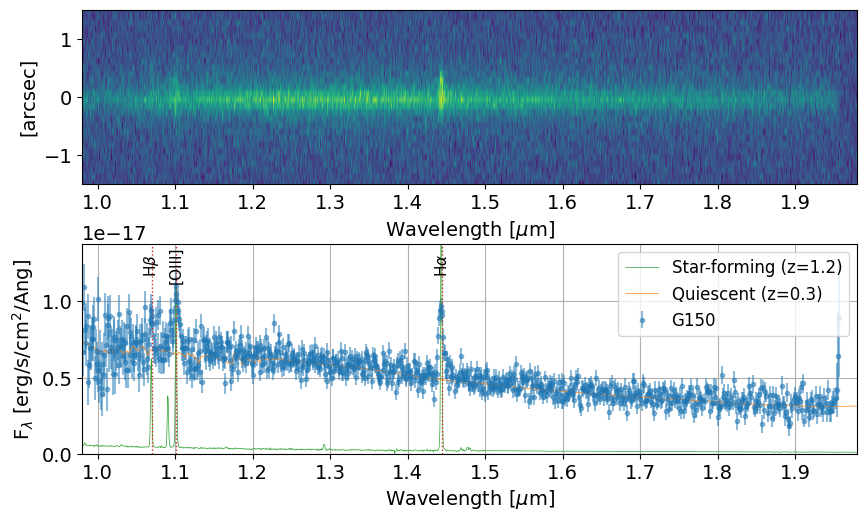

In [191]:
os.chdir(os.path.join(HOME_PATH, root, 'Extractions'))


z = 1.2

aspect = 0.075
pixscale = 0.11

y0 = 0
y1 = -1
yscale = 1.25

lw = 1
labels = 1
fontsize = 11

##############
# 2D SPECTRA #
##############
f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
print(f_2d)
twod_hdu = pyfits.open(f_2d)
print(twod_hdu.info())
print()


twod_hdu[1].header

sci = twod_hdu[1].data
head = twod_hdu[1].header
print(head)

w0 = head["WMIN"]
w1 = head['WMAX']


naxis1 = head['naxis1']
naxis2 = head['naxis2']
print(naxis1)
print(naxis2)
edge = naxis2*pixscale/2
print(edge)

extent = [w0,w1,-1*edge,edge]


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.imshow(sci, extent=extent)
#ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.xaxis.set_major_locator(MultipleLocator(0.1))

#ax1.axes.get_yaxis().set_visible(False)
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.set_aspect(aspect)
ax1.set_xlabel("Wavelength [$\mu$m]")
ax1.set_ylabel("[arcsec]")

ax1.set_ylim(-1.5,1.5)

#plt.show()

##############
# 1D SPECTRA #
##############
f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)

tbl = Table(oned_hdu['GR'].data)

flux = tbl['flux']/tbl['flat']
wav = tbl['wave']/1e4

filt = (wav > w0) & (wav < w1)

ax2 = fig.add_subplot(212)
ax2.errorbar(wav, flux, yerr=tbl["err"]/tbl['flat'],
             marker='.', linestyle='None', alpha=0.5, label="G150")

#if not i: label = "model"
#else: label = ""
#ax2.plot(wav, tbl['line']/tbl['flat'], color="g", alpha=0.5, label=label)

#if not i: label = "contam"
#else: label = ""
#ax2.plot(wav, tbl['contam']/tbl['flat'], color="r", alpha=0.5, label=label)

names = ["Star-forming (z=1.2)", "Quiescent (z=0.3)"]
colors = ["tab:green", "tab:orange"]
for i in range(len(tbl_spec)):
    ax2.plot(tbl_spec[i]['WAV_NM']/1000.,tbl_spec[i]['FLUX'],color=colors[i], alpha=1.0, 
             label=names[i],lw=0.5)



yy0 = 1
yy1 = -1

if np.nanmin(flux[filt]) < yy0: yy0 = np.nanmin(flux[filt])
if np.nanmax(flux[filt]) > yy1: yy1 = np.nanmax(flux[filt])

if y0 == -1:
    if yy0 > 0:
        y0 = yy0/yscale
    else:
        y0 = yscale*yy0
if y1 == -1: y1 = yscale*yy1
    


#ax2.text(0.95, 0.96, 'z = %.2f' % (z), ha='right', va='top', transform=ax2.transAxes, fontsize=14)


for line,wemit in emlines:
    wobs = (1+z)*wemit
    #FWHM = vel * wobs / c_km
    if wobs/1e4 > w0 and wobs/1e4 < w1:

        ax2.plot([wobs/1e4,wobs/1e4],[y0,y1],":",lw=lw,c="tab:red")

        if labels:
            ax2.text(wobs/1e4,0.9*y1,line,fontsize=fontsize,
                        rotation='vertical',
                        horizontalalignment='center',
                        verticalalignment='center')


ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.set_xlim(w0, w1); ax2.set_ylim(y0,y1)
#ax[3].semilogy(); 
ax2.grid()
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel(r'F$_\lambda$ [erg/s/cm$^2$/Ang]')

ax2.legend(fontsize=12)

plt.show()

gravlens_00001.stack.fits
Filename: gravlens_00001.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  SCI         GR,270.0 ImageHDU        45   (908, 64)   float32   
  2  WHT         GR,270.0 ImageHDU        22   (908, 64)   float32   
  3  CONTAM      GR,270.0 ImageHDU        22   (908, 64)   float32   
  4  MODEL       GR,270.0 ImageHDU        24   (908, 64)   float32   
  5  KERNEL      GR,270.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         GR  ImageHDU        44   (908, 64)   float32   
  7  WHT         GR  ImageHDU        22   (908, 64)   float32   
  8  MODEL       GR  ImageHDU        24   (908, 64)   float32   
  9  KERNEL      GR  ImageHDU        22   (64, 64)   float32   
None

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array di

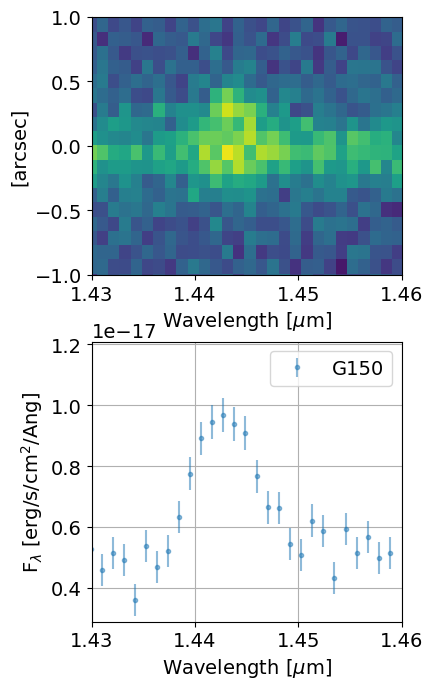

In [130]:
w0 = 1.43
w1 = 1.46

f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
print(f_2d)
twod_hdu = pyfits.open(f_2d)
print(twod_hdu.info())
print()

f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)


twod_hdu[1].header

sci = twod_hdu[1].data
head = twod_hdu[1].header
print(head)

ww0 = head["WMIN"]
ww1 = head['WMAX']

pixscale = 0.11
naxis1 = head['naxis1']
naxis2 = head['naxis2']
print(naxis1)
print(naxis2)
edge = naxis2*pixscale/2
print(edge)

extent = [ww0,ww1,-1*edge,edge]

y0 = -1
y1 = -1


fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(211)
ax1.imshow(sci, extent=extent)
#ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.xaxis.set_major_locator(MultipleLocator(0.01))

#ax1.axes.get_yaxis().set_visible(False)
#ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.set_aspect(0.0125)
ax1.set_xlabel("Wavelength [$\mu$m]")
ax1.set_ylabel("[arcsec]")

ax1.set_xlim(w0, w1); 
ax1.set_ylim(-1, 1); 


#plt.show()


tbl = Table(oned_hdu['GR'].data)

flux = tbl['flux']/tbl['flat']
wav = tbl['wave']/1e4

filt = (wav > w0) & (wav < w1)


yy0 = 1
yy1 = -1
yscale = 1.25

ax2 = fig.add_subplot(212)
ax2.errorbar(wav, flux, yerr=tbl["err"]/tbl['flat'],
             marker='.', linestyle='None', alpha=0.5, label="G150")

#if not i: label = "model"
#else: label = ""
#ax2.plot(wav, tbl['line']/tbl['flat'], color="g", alpha=0.5, label=label)

#if not i: label = "contam"
#else: label = ""
#ax2.plot(wav, tbl['contam']/tbl['flat'], color="r", alpha=0.5, label=label)

if np.nanmin(flux[filt]) < yy0: yy0 = np.nanmin(flux[filt])
if np.nanmax(flux[filt]) > yy1: yy1 = np.nanmax(flux[filt])

if y0 == -1:
    if yy0 > 0:
        y0 = yy0/yscale
    else:
        y0 = yscale*yy0
if y1 == -1: y1 = yscale*yy1

    
ax2.xaxis.set_major_locator(MultipleLocator(0.01))
ax2.set_xlim(w0, w1); ax2.set_ylim(y0,y1)
#ax[3].semilogy(); 
ax2.grid()
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel(r'F$_\lambda$ [erg/s/cm$^2$/Ang]')

ax2.legend()

plt.show()

In [153]:
print(os.getcwd())

/Users/gwalth/data/Roman/grizli/sims/gravlens/Extractions


In [ ]:
t0 = time.time()

print(Roman)

import pickle

# ~ 5GB file
with open('Roman_GrismFLT.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Roman, f, pickle.HIGHEST_PROTOCOL)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
t0 = time.time()

import pickle

with open('Roman_GrismFLT.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    Roman = pickle.load(f)
    
t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
print(Roman)
print(Roman.__dict__)

In [ ]:
print()
all_objects = muppy.get_objects()
print("All objects = %i" % (len(all_objects)))
sum1 = summary.summarize(all_objects)
summary.print_(sum1)

## (TESTING) Roman pad and magnitude test - SKIP

In [ ]:
### Roman GRS grism

# test set
#pads = [0]
#mag_limits = [18,20]

pads = [0,100,200,400,800]
mag_limits = [18,20,22,24,26]

info_list = []
cat_list = []
i = 0 # iter
N = len(pads) * len(mag_limits) # total iter

for pad in pads:
    for mag_limit in mag_limits:

        Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                                      ref_file=new_direct, ref_ext=1,
                                      seg_file=seg, shrink_segimage=True)

        Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
        Roman.catalog = Roman_cat

        mask = Roman_cat['MAG_AUTO'] < mag_limit
        Ntot = mask.sum()
        
        Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
        
        ids_ext = []
        for id in Roman.object_dispersers:
            is_cgs, spectrum_1d, beam = Roman.object_dispersers[id]
            if len(beam) > 0: 
                ids_ext.append(id)
        
        ids_ext = np.array(ids_ext)
        Next = len(ids_ext)
        
        print()
        print('iter = %i of %i' % (i+1,N))
        print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
        print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))
        print("\n")
        
        info_list.append([pad, mag_limit, Ntot, Next])
        
        Roman_extract = Roman.catalog[ids_ext - 1] 
        cat_list.append(Roman_extract)
        
        fig = plt.figure(figsize=[20,10])
        # Direct
        ax1 = fig.add_subplot(121)
        ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')
        ax1.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
                   edgecolor='white', facecolor='none', alpha=0.7)
        ax1.set_xticklabels([])
        ax1.set_title('pad=%d  mag_limit=%d  Ntot=%d  Next=%d' %(pad,mag_limit,Ntot,Next))

        # Grism
        ax2 = fig.add_subplot(122)
        ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
        ax2.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
                   edgecolor='green', facecolor='none', alpha=0.7)
        ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
        fig.tight_layout(pad=4.0)   
        
        i += 1
        
#print(info_list)


print("\n\n")
print("#"*12)
print("Test summary")
print("#"*12)
print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
for info in info_list:
    pad, mag_limit, Ntot, Next = info
    print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))

print()
print(len(cat_list))
#print(cat_list)

## Check simulation
[top](#Table-of-Contents)

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [ ]:
mag_limit = 30

In [ ]:
Roman_all,Roman_magcut,Roman_extract = check_sims(Roman, mag_limit)

In [ ]:
print(Roman_extract)

In [ ]:
Roman.catalog[:20].show_in_notebook()

In [ ]:
#wcs = pywcs.WCS(head)

## Show direct images and slitless spectra
[top](#Table-of-Contents)

In [ ]:
### Show them!

fig = plt.figure(figsize=[10,20])
# Direct
axt = fig.add_subplot(211)
axt.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.1, cmap='inferno')
# Grism
axb = fig.add_subplot(212)
axb.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', cmap='gray_r', vmin=-0.02, vmax=0.02)
axb.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
    

axt.set_yticklabels([])
axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

## Show direct images and slitless spectra (with sources overplotted)

This is a check to see if there is a field dependence (or magnitude) to the failed simulations.

In [ ]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,20])

#Roman_extract = Roman.catalog[0][0]

# Direct
#ax1 = fig.add_subplot(211, projection=wcs)
ax1 = fig.add_subplot(211)
ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='viridis')

ax1.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
           edgecolor='white', facecolor='none', alpha=0.5)

#ax1.set_xticklabels([])
print(ax1.get_xlim())
print(ax1.get_ylim())
    
# Grism
#ax2 = fig.add_subplot(212, projection=wcs)
ax2 = fig.add_subplot(212)
ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='gray_r')

ax2.scatter(Roman_extract['x_flt'], Roman_extract['y_flt'], s=100,
           edgecolor='green', facecolor='none', alpha=0.5)


ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
print(ax2.get_xlim())
print(ax2.get_ylim())

fig.tight_layout(pad=4.0)

In [ ]:
print(phot.colnames)
print(phot["X_WORLD","Y_WORLD"])
print(phot["MAG_AUTO"])

## (TESTING) Filter catalog based on position on the detector and magnitude - SKIP

In [ ]:
# OLD - DO NOT RUN!

cat = Roman.catalog
cat["NUMBER","MAG_AUTO","id","ra","dec","x_flt","y_flt"]
#cat.colnames

x_filt = (cat['x_flt'] > 2400) & (cat['x_flt'] < 2600)
y_filt = (cat['y_flt'] > 3900) & (cat['y_flt'] < 4100)
mag_filt = (cat['MAG_AUTO'] < 24)

filt = x_filt & y_filt & mag_filt

print(cat[filt]['MAG_AUTO','id',"ra","dec","x_flt","y_flt"])

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
from importlib import reload
reload(grizli.model)

## Cygnusc redshift fitting and memory testing

In [ ]:
from grizli_functions import grizli_fit_all_z,grizli_fit_all_z_async,grizli_fit_all_z_sync          
from grizli_functions import grizli_fit_all_z_2, grizli_fit_all_z_3                                 
from grizli_functions import test_func,test_func_sync                                               
from grizli_functions import get_sim_info

In [ ]:
# source list                                                                                       
sources = np.array(get_sim_info())                                                                  
print(sources)                                                                                      
print(len(sources))
                                                    
filt = sources < 10 # where I quit (memory leak somewhere...)                                      
#print(sources[filt])                                                                               
#print(len(sources[filt]))                                                                          
                                                                                                    
sources = list(sources[filt])                                                                       
#sources = list(sources)      

grizli_fit_all_z_3(HOME_PATH='/home/gwalth/data/Roman/grizli/sims/',                                
                 field="field_0017", root='sim_v3',z2=6.0, sources=sources)

## Loop over all objects and fit their redshifts
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

In [ ]:
# Test 
#Nl = [id for id in phot['NUMBER']][:2]
#Nl = [id for id in Roman_extract['NUMBER']][:2]

# Large Test 
#Nl = [id for id in phot['NUMBER']][:10]
#Nl = [id for id in Roman_extract['NUMBER']][:1000]

# All sources
#Nl = [id for id in phot['NUMBER']]        # original photometry Table
Nl = [id for id in Roman_extract['NUMBER']] # cleaned Table

# Problem, might need try/except in fitting
print(Nl)

#print(Roman_extract['MAG_AUTO'])

In [ ]:
print()                                                                                     
all_objects = muppy.get_objects()                                                           
print("All objects = %i" % (len(all_objects)))                                              
sum1 = summary.summarize(all_objects)                                                       
summary.print_(sum1)

In [ ]:
t0 = time.time()

fwhm = 325 # km/s
#t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
#t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
temp0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
temp1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


for id in Nl:

    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    
    #############################
    # old lines of code (working)
    #############################   
    #cutout.write_fits() # still learning
    #beam = 'beam__%05d.grism.A.fits' % (id)
    #new_beam = beam.replace(".fits","_GLW.fits")

    #ext = 0
    #hdu = pyfits.open(beam)
    #hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    #hdu.writeto(new_beam,clobber=True)

    #mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    #mb.write_master_fits()
    
    
    ###########################
    # new lines of code to test
    ###########################
    hdu = cutout.write_fits(get_hdu=True)
    ext = 0
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

    beam = 'beam_%05d.grism.A.fits' % (id)
    hdu.writeto(beam,clobber=True)

    mb = multifit.MultiBeam([beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()
    
    # kludge
    os.remove(beam)
    ###########################
    
    
    

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    #memory_tracker.print_diff()
    
    print()
    all_objects = muppy.get_objects()
    print("All objects = %i" % (len(all_objects)))
    sum1 = summary.summarize(all_objects)
    summary.print_(sum1)
    

t1 = time.time()

print()
print("Finished in %.1f seconds" % (t1-t0))

In [ ]:
print(type(Roman))

## Inspect Redshift Fitting Results
[top](#Table-of-Contents)

In [ ]:
def redshift_analysis_od(root,id,save_lines=3):

    full_obj = OrderedDict()
   
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    h0 = full_hdu[0].header
    line_keys = ['ID','RA','DEC','REDSHIFT','NUMLINES']
    #print(h0)
    for lk in line_keys:
        #h0[lk],h0.comments[lk]
        #print(h0[lk],)
        full_obj[lk] = h0[lk]
    
    # read all of the lines
    #print(h0['NUMLINES'])
    lines_list = []
    for i in range(h0['NUMLINES']):
        #print(i+1)
        od = OrderedDict({"line":h0["LINE%03d" % (i+1)],
                          "flux":h0["FLUX%03d" % (i+1)],
                          "err":h0["ERR%03d" % (i+1)]})                  
        lines_list.append(od)
                          
                          
    #print(lines_list)
    line_tbl = Table(lines_list)
    line_tbl.sort("flux")
    line_tbl.reverse()
    
    for i in range(save_lines):
        try:
            full_obj["LINE%03d" % (i+1)] = line_tbl['line'][i]
            full_obj["FLUX%03d" % (i+1)] = line_tbl['flux'][i]
            full_obj["ERR%03d" % (i+1)] = line_tbl['err'][i]
        except IndexError:
            full_obj["LINE%03d" % (i+1)] = "None"
            full_obj["FLUX%03d" % (i+1)] = 99.9
            full_obj["ERR%03d" % (i+1)] = -99.9
    
    
    h1 = full_hdu['ZFIT_STACK'].header
    zfit_keys = ['CHIMIN','DOF','Z02','Z16','Z50','Z84','Z97','ZWIDTH1',
                 'ZWIDTH2','Z_RISK','MIN_RISK','Z_MAP','GAM_LOSS']
    
    for zfk in zfit_keys:
        #h1[zfk],h1.comments[zfk]
        #print(h1[zfk],)
        full_obj[zfk] = h1[zfk]
    
    return full_obj
    


In [ ]:
def plot_redshifts(tbl):

    fig = plt.figure()
    p1 = fig.add_subplot(111)
    p1.scatter(tbl["ZWIDTH1"], tbl["ZWIDTH2"])

    p1.plot([0.0001,10.0],[0.05,0.05],"--",c="k")
    p1.plot([0.05,0.05],[0.0001,10.0],"--",c="k")

    p1.set_xlabel("zwidth1 [16th and 84th p(z) percentile]")
    p1.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
    p1.set_xscale("log")
    p1.set_yscale("log")
    p1.set_xlim(0.0001,10.0)
    p1.set_ylim(0.0001,10.0)

    fig = plt.figure(figsize=(12,4))
    p1 = fig.add_subplot(121)
    p1.scatter(tbl["REDSHIFT"], tbl["ZWIDTH1"])
    #p1.plot([0,3.5],[0.1,0.1],"--",c="k")
    p1.plot([0,3.5],[0.05,0.05],"--",c="k")
    p1.set_xlabel("Redshift")
    p1.set_ylabel("zwidth1 [16th and 84th p(z) percentile]")
    p1.set_yscale("log")
    p1.set_ylim(0.0001,10.0)

    p2 = fig.add_subplot(122)
    p2.scatter(tbl["REDSHIFT"], tbl["ZWIDTH2"])
    #p2.plot([0,3.5],[0.1,0.1],"--",c="k")
    p2.plot([0,3.5],[0.05,0.05],"--",c="k")
    p2.set_xlabel("Redshift")
    p2.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
    p2.set_yscale("log")
    p2.set_ylim(0.0001,10.0)
    
    print(len(tbl))

In [ ]:
def plot_redshifts2(tbl,zcut=0.01):

    filt1 = tbl["ZWIDTH1"] < zcut
    tbl_filt1 = tbl[filt1]

    fig = plt.figure(figsize=(12,10))

    p1 = fig.add_subplot(221)
    p1.scatter(tbl["REDSHIFT"], tbl["ZWIDTH1"], s=2, c="k")
    p1.scatter(tbl_filt1["REDSHIFT"], tbl_filt1["ZWIDTH1"])
    #p1.plot([0,3.5],[0.1,0.1],"--",c="k")
    p1.plot([0,3.5],[zcut,zcut],"--",c="k")
    p1.set_xlabel("Redshift")
    p1.set_ylabel("z$_{width1}$ [16th and 84th p(z) percentile]")
    p1.set_yscale("log")
    p1.set_ylim(0.0001,10.0)

    p2 = fig.add_subplot(222)
    p2.scatter(tbl["REDSHIFT"], tbl["MAG_AUTO"], s=2, c="k")
    p2.scatter(tbl_filt1["REDSHIFT"], tbl_filt1["MAG_AUTO"])
    #p2.plot([0,3.5],[0.1,0.1],"--",c="k")
    #p2.plot([0,3.5],[0.05,0.05],"--",c="k")
    p2.set_xlabel("Redshift")
    p2.set_ylabel("Mag")
    #p2.set_yscale("log")
    #p2.set_ylim(0.0001,10.0)

    filt2 = tbl["ZWIDTH2"] < zcut
    tbl_filt2 = tbl[filt2]

    p3 = fig.add_subplot(223)
    p3.scatter(tbl["REDSHIFT"], tbl["ZWIDTH2"], s=2, c="k")
    p3.scatter(tbl_filt2["REDSHIFT"], tbl_filt2["ZWIDTH2"])
    #p3.plot([0,3.5],[0.1,0.1],"--",c="k")
    p3.plot([0,3.5],[zcut,zcut],"--",c="k")
    p3.set_xlabel("Redshift")
    p3.set_ylabel("z$_{width2}$ [2.5th and 97.5th p(z) percentile]")
    p3.set_yscale("log")
    p3.set_ylim(0.0001,10.0)

    p4 = fig.add_subplot(224)
    p4.scatter(tbl["REDSHIFT"], tbl["MAG_AUTO"], s=2, c="k")
    p4.scatter(tbl_filt2["REDSHIFT"], tbl_filt2["MAG_AUTO"])
    #p4.plot([0,3.5],[0.1,0.1],"--",c="k")
    #p4.plot([0,3.5],[0.05,0.05],"--",c="k")
    p4.set_xlabel("Redshift")
    p4.set_ylabel("Mag")
    #p4.set_yscale("log")
    #p4.set_ylim(0.0001,10.0)

    print(len(tbl))
    print(len(tbl[filt1]))
    print(len(tbl[filt2]))
    
    return filt1,filt2


Important note:

In the in initial catalog generation, I need RA and DEC or some other identifier to push along and tag the sources properly for their magnitudes and redshifts.  If I can map the sources correctly then I should be able to adjust any magnitude differences.

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
#print(ids)
print("N =",len(ids))

In [ ]:
print(ids)

In [ ]:
#ids = [652, 653]

Takes ~2 min to read 1000 files into a table

In [ ]:
redshift_rows = []
for id in ids:
    redshift_od = redshift_analysis_od(root,id,save_lines=5)
    redshift_rows.append(redshift_od)

redshift_fits = Table(redshift_rows)
print(redshift_fits)

In [ ]:
print(redshift_fits.colnames)

ind = 1
print(redshift_fits['LINE%03d' % ind])
print(redshift_fits['FLUX%03d' % ind])
print(redshift_fits['ERR%03d' % ind])

print(np.min(redshift_fits['FLUX%03d' % ind]))
print(np.max(redshift_fits['FLUX%03d' % ind]))


### Description of tables

The available tables for analysis

phot          - SExtractor table
Roman         - Grizli data
Roman_all     - output of check_sims, all sources
Roman_magcut  - output of check_sims, only sources above the magnitude cut
Roman_extract - output of check_sims, only sources extracted
redshift_fits - all the redshift fits of the Roman_extract (full.fits) read into a table
primer        - original input sources and true redshifts


Roman_extract, redshift_fits and primer need to be joined into one table

Roman_extract and redshift_fits can be joined based on SExtractor id --> all_tbl
primer needs to be joined based on RA,Dec  


all_tbl         - join between Roman_extract and redshift_fits
match_tbl       - join between all_tbl and primer
match_clean_tbl - sources outside of match radius removed (>1")

In [ ]:
print(redshift_fits.colnames)
#print(redshift_fits['ID'])

In [ ]:
print(Roman_extract.colnames)
#print(Roman_extract['NUMBER','id'])

In [ ]:
print(primer.colnames)
#print(primer['NUMBER'])

In [ ]:
Roman_extract.rename_column('NUMBER', 'ID')

In [ ]:
all_tbl = join(Roman_extract, redshift_fits, keys='ID')
print(all_tbl)

In [ ]:
#plot_redshifts(all_tbl)
zfilt1,zfilt2 = plot_redshifts2(all_tbl)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.01)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.005)
#zfilt1,zfilt2 = plot_redshifts2(redshift_fits, zcut = 0.001)

<b>Skip</b> One matching method

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
c_all = SkyCoord(ra=all_tbl["RA"]*u.degree, dec=all_tbl["DEC"]*u.degree)
#idx_c_prime, idx_c_all, d2d, d3d = c_all.search_around_sky(c_prime, 5*u.arcsec)
idx_c_prime, idx_c_all, d2d, d3d = c_all.search_around_sky(c_prime, 1*u.deg)

#np.all(d2d < 5*u.arcsec)

#dist_filt = d2d < 1.0*u.arcsec
dist_filt = d2d < 1.0*u.deg

print(idx_c_prime[dist_filt])
print(len(idx_c_prime[dist_filt]))
print(idx_c_all[dist_filt])
print(len(idx_c_all[dist_filt]))

Another matching method (preferred)

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

c_prime = SkyCoord(ra=primer["RA"]*u.degree, dec=primer["DEC"]*u.degree)
c_all = SkyCoord(ra=all_tbl["RA"]*u.degree, dec=all_tbl["DEC"]*u.degree)

idx, d2d, d3d = c_prime.match_to_catalog_sky(c_all)


print(idx)
print(d2d)
print(len(idx))
print(len(c_prime))
print(len(c_all))

filt = d2d < 1*u.arcsec

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.hist(d2d[filt].value*3600.,bins=20)

In [ ]:
primer['idx'] = idx
primer['d2d'] = d2d
print(primer.colnames)

In [ ]:
all_tbl['idx'] = np.arange(len(all_tbl))
print(all_tbl.colnames)
#print(all_tbl['idx'])

In [ ]:
match_tbl = join(all_tbl, primer, keys='idx')
#print(match_tbl)

In [ ]:
#filt = match_tbl['d2d'] < 1.0*u.arcsec
filt = match_tbl['d2d'] < 0.4*u.arcsec
match_clean_tbl = match_tbl[filt]
print(len(match_clean_tbl))

In [ ]:
z_fit = match_clean_tbl["REDSHIFT_1"]
z_true = match_clean_tbl["REDSHIFT_2"]

mag_fit  = match_clean_tbl["MAG_AUTO"]
mag_true = match_clean_tbl["MAG_F1600W"]

filt = match_clean_tbl["MAG_AUTO"] < 24

In [ ]:
fig = plt.figure(figsize=(12,12))

p1 = fig.add_subplot(221)
p1.scatter(z_fit, z_true, s=5, c="k")
p1.scatter(z_fit[filt], z_true[filt], s=30, c="orange",alpha=0.5)
p1.plot([0.05,3.05],[0.0,3.0],"--",c="b",alpha=0.5)
p1.plot([0.0,3.0],[0.05,3.05],"--",c="b",alpha=0.5)
p1.set_xlim(0,3)
p1.set_ylim(0,3)
p1.set_xlabel("Fit redshift")
p1.set_ylabel("True redshift")

p2 = fig.add_subplot(222)
p2.scatter(mag_fit, mag_true, s=5, c="k")
p2.plot([19.2,30.2],[19,30],"--",c="b",alpha=0.5)
p2.plot([19,30],[19.2,30.2],"--",c="b",alpha=0.5)
p2.set_xlim(19,30)
p2.set_ylim(19,30)
p2.set_xlabel("Measured mag")
p2.set_ylabel("True mag")

p3 = fig.add_subplot(223)
p3.hist(z_fit)
p3.set_xlabel("Fit redshift")

p4 = fig.add_subplot(224)
p4.hist(z_true)
p4.set_xlabel("True redshift")

In [ ]:
dz = (z_true - z_fit)/(1+z_true)

fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
p1.hist(dz,bins=100)

#p1.hist(dz,bins=1000)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

In [ ]:
match_clean_tbl['SN001'] = match_clean_tbl['FLUX001']/match_clean_tbl['ERR001']
match_clean_tbl['SN002'] = match_clean_tbl['FLUX002']/match_clean_tbl['ERR002']
match_clean_tbl['SN003'] = match_clean_tbl['FLUX003']/match_clean_tbl['ERR003']
match_clean_tbl['SN004'] = match_clean_tbl['FLUX004']/match_clean_tbl['ERR004']
match_clean_tbl['SN005'] = match_clean_tbl['FLUX005']/match_clean_tbl['ERR005']

fig = plt.figure(figsize=(12,5))
p1 = fig.add_subplot(111)
p1.hist(match_clean_tbl['SN001'],bins=400,label="LINE001",alpha=0.7)
p1.hist(match_clean_tbl['SN002'],bins=400,label="LINE002",alpha=0.7)
p1.hist(match_clean_tbl['SN003'],bins=200,label="LINE003",alpha=0.7)
p1.hist(match_clean_tbl['SN004'],bins=200,label="LINE005",alpha=0.7)
p1.hist(match_clean_tbl['SN005'],bins=200,label="LINE005",alpha=0.7)
p1.set_xlabel("S/N")
p1.set_xlim(0,15)
p1.legend()

In [ ]:
filt1 = match_clean_tbl['SN001'] > 6.5
print("Num. sources (S/N > 6.5) =",len(match_clean_tbl['SN001'][filt1]))

match_clean_sn65_tbl = match_clean_tbl[filt1]
print("Num. sources w/ 2 lines (S/N > 3)")
filt2 = match_clean_sn65_tbl['SN002'] > 3
print(len(match_clean_sn65_tbl[filt2]))

print("Num. sources w/ 3 lines (S/N > 3)")
filt3 = match_clean_sn65_tbl['SN003'] > 3
print(len(match_clean_sn65_tbl[filt3]))



In [ ]:
def sample_numbers(tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005):
    
    filt = tbl[sn_key] > sn
    
    print('Num. sources =',len(tbl[sn_key]))
    print('Num. sources (S/N > %.1f) =' % (sn),len(tbl[sn_key][filt]))
    
    z_fit = tbl["REDSHIFT_1"][filt]
    z_true = tbl["REDSHIFT_2"][filt]

    dz = (z_true - z_fit)/(1+z_true)

    #zfilt = np.abs(dz) < sigma_dz
    zfilt = np.abs(dz) < sigma_dz*(1+z_true)

    tbl_sn = tbl[filt]
    tbl_sn_dz = tbl_sn[zfilt]

    print("Num. sources (dz < %.3f) =" % (sigma_dz),len(z_fit[zfilt]))
    print("Frac. sources (dz < %.3f) = %.4f" % (sigma_dz,len(z_fit[zfilt])/len(z_fit)))
    print()
    
    fig = plt.figure(figsize=(4,4))
    p1 = fig.add_subplot(111)
    p1.hist(z_fit,bins=15,label="all")
    p1.hist(z_fit[zfilt],bins=15,label="z < %.3f" % (sigma_dz))
    p1.set_xlabel("redshift")
    p1.legend()
    plt.show()
    

In [ ]:
sample_numbers(match_clean_tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005)
sample_numbers(match_clean_tbl, sn_key='SN001', sn=5.0, sigma_dz=0.005)
sample_numbers(match_clean_tbl, sn_key='SN001', sn=3.0, sigma_dz=0.005)

In [ ]:
fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
#p1.hist(dz,bins=100)

p1.hist(dz,bins=200)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

In [ ]:
from collections import Counter

def emline_bar_chart(data,title=""):

    c1 = Counter(data)
    c2 = OrderedDict(c1.most_common())

    ind = np.arange(len(c1))
    width=0.75

    fig = plt.figure()
    p1 = fig.add_subplot(111)
    p1.bar(ind, c2.values(), width)
    p1.set_xticks(ind)
    p1.set_xticklabels(c2.keys(), rotation = 90)
    p1.set_title(title)
    plt.show()
    
def emline_bar_chart2(data1,data2,title=""):

    c1 = Counter(data1)
    c1o = OrderedDict(c1.most_common())
    
    c2 = Counter(data2)
    c2o = OrderedDict(c2.most_common())
    
   
    ind1 = np.arange(len(c1))
    ind2 = np.arange(len(c2))
    width=0.75

    fig = plt.figure(figsize=(12,6))
    p1 = fig.add_subplot(121)
    p1.bar(ind1, c1o.values(), width)
    p1.set_xticks(ind1)
    p1.set_xticklabels(c1o.keys(), rotation = 90)
    p1.set_title(title)
    
    p2 = fig.add_subplot(122)
    p2.bar(ind2, c2o.values(), width)
    p2.set_xticks(ind2)
    p2.set_xticklabels(c2o.keys(), rotation = 90)
    p2.set_title(title)
    plt.show()
    
    plt.show()


In [ ]:
emline_bar_chart2(match_clean_tbl['LINE001'],match_clean_sn65_dz005_tbl['LINE001'], 
                  title = "1st brightest line")

#emline_bar_chart(match_clean_tbl['LINE001'],title = "1st brightest line")
emline_bar_chart(match_clean_tbl['LINE002'],title = "2nd brightest line")
emline_bar_chart(match_clean_tbl['LINE003'],title = "3rd brightest line")
emline_bar_chart(match_clean_tbl['LINE004'],title = "4th brightest line")
emline_bar_chart(match_clean_tbl['LINE005'],title = "5th brightest line")

In [ ]:
print(dir())
#print(__dict__)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

#primer_cat = "ATLAS_1deg_subsample_cat_random_primer.cat"
#primer_cat = "ATLAS_1deg_subsample_primer_small.lis"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#full_hdu.info()
print('id = {0}'.format(id))
print('N = {0}'.format(len(ids)))

In [ ]:
print("Number of extensions", len(full_hdu))
full_hdu['ZFIT_STACK'] # ext=1
full_hdu['COVAR']      # ext=2
full_hdu['TEMPL']      # ext=3
full_hdu['SEG']        # ext=4

In [ ]:
print("Number of extensions =",len(full_hdu))
head = full_hdu[0].header
full_hdu[0].header

In [ ]:
print("Number of extensions =",len(full_hdu))
full_hdu['ZFIT_STACK'].header

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))


def process_full_fits(root,id):
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    head = full_hdu[0].header
    
    numlines = head['NUMLINES']
    redshift = head['REDSHIFT']
    
    lines_list = []
    
    for i in range(numlines):
        line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                                      "flux":head["FLUX%03d" % (i+1)],
                                      "err":head["ERR%03d" % (i+1)]}))
    line_tbl = Tabel(line_list)
    line_tbl.sort("flux")
    line_tbl.reverse()
    
    return line_tbl[:3] # return 3 brightest lines
        
#####################    
    

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
print(ids)
print("N =",len(ids))



N = head['NUMLINES']

line_list = []
for i in range(N):
    line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                                  "flux":head["FLUX%03d" % (i+1)],
                                  "err":head["ERR%03d" % (i+1)]}))
    
#print(line_list)

line_tbl = Table(line_list)


line_tbl["SN"] = line_tbl["flux"]/line_tbl["err"]
print(line_tbl)


filt = line_tbl["SN"] > 2.0
print(line_tbl[filt])
    
    

In [ ]:
N = head['NUMLINES']

line_list = []
for i in range(N):
    line_list.append(OrderedDict({"line":head["LINE%03d" % (i+1)],
                      "flux":head["FLUX%03d" % (i+1)],
                      "err":head["ERR%03d" % (i+1)]}))
    
#print(line_list)

line_tbl = Table(line_list)


line_tbl["sn"] = line_tbl["flux"]/line_tbl["err"]
print(line_tbl)

#filt = line_tbl["SN"] > 2.0
#print(line_tbl[filt])
line_tbl.sort("flux")
line_tbl.reverse()

print(line_tbl)

print(line_tbl[:3])

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

id = 25

f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)
print(oned_hdu[1].header)
print(oned_hdu.info())
grism = Table(oned_hdu['GRISM'].data)
print(grism.colnames)

signal = np.sum(grism['flux'])
noise = np.sqrt(np.sum(grism['err']**2))
print(signal)
print(noise)

print(signal/noise)

#full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#print(full_hdu.info())
print(grism['line'])
plt.plot(grism['flat'])

In [ ]:
S_N = []
for id in phot['NUMBER']:
    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    oned_hdu = pyfits.open(f_1d)
    grism = Table(oned_hdu['GRISM'].data)

    signal = np.sum(grism['flux'])
    noise = np.sqrt(np.sum(grism['err']**2))
    S_N.append(signal/noise)

phot['S_N'] = np.array(S_N)

In [ ]:
print(phot['S_N'])

In [ ]:
plt.scatter(phot['S_N'],phot['MAG_AUTO'])

In [ ]:
plt.hist(phot['S_N'],bins=10,range=[0,20])

In [ ]:
filt = phot['S_N'] < 6.5
print(len(phot[filt]))

# Appendix

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

In [ ]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#small 
#r0,d0 = 9.9667504,  0.0240604 # 19.94
#r0,d0 = 9.9542018, -0.0588458 # 21.10
#r0,d0 = 9.9490562, -0.0373860 # 22.13
#r0,d0 = 9.9465051, -0.0405907 # 23.01
#r0,d0 = 9.9589560,  0.0124919 # 23.98

#random                                MAG    ATLAS NUMBER
#r0,d0 = 10.0011107466,  0.0149484929 # 18.49  23961 continuum
#r0,d0 = 10.0412372492,  0.0029643496 # 19.87  8063 mostly continuum
#r0,d0 = 10.005562076,  -0.0566183098 # 20.79  8990 continuum
#r0,d0 =  9.9664018228, -0.0055298638 # 20.91  606 continuum
#r0,d0 = 10.0265397928, -0.0393050944 # 20.97  2118 emission, probably Ha (good!!!), modspec=1752
#r0,d0 =  9.958860925,  -0.0350264133 # 20.98 23115 
#r0,d0 = 10.0098736134, -0.0298934341 # 21.95  2388 emission
#r0,d0 =  9.9912782697, -0.0334312864 # 22.92  21289 emission or contaminate?
#r0,d0 = 10.0110716308,  0.05128653   # 23.97  12314 ?

# 2118 old
# 1571 new
r0,d0 = 10.0265397928, -0.0393050944 # 20.97  Ha (good!!!)


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()


ix = Roman.catalog['id'] == id
x0, y0 = Roman.catalog['x_flt'][ix][0], Roman.catalog['y_flt'][ix][0]
print(Roman.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Roman.object_dispersers[id])

is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
if id in Roman.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r')
#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Roman.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## aXeSIM predictions based on conf file
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

In [ ]:
from grizli import grismconf

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF")
conf = grismconf.load_grism_config("./Roman.det1.07242020.conf")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
print(os.getcwd())

In [ ]:
for i in range(1,19): 
    conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det%i.07242020.conf" % (i)) 
    #conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det%i.07242020.conf" % (i))
    dx = conf.dxlam["A"]
    print(dx)
    dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
    print(dy)
    print(lam)
    conf.show_beams()

## Show 2D beam
[top](#Table-of-Contents)

In [ ]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    #axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [14]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
   
    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [ ]:
# determine flux in Ang for the source in the direct image

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]

f_scale = ab2flux(mab,15800.)

## Simple SN calculations based on the spcontetc
[top](#Table-of-Contents)

In [15]:
# Per pix S/N=1
mag_per_pix_w0 = 21.9       # 1.00 um
mag_per_pix_w1 = 21.9       # 1.93 um
mag_per_pix_deepest = 22.7  # 1.34 um

In [16]:
ab2flux(mag_per_pix_w0,10000.)
ab2flux(mag_per_pix_deepest,13400.)

5.042054612716202e-19

/Users/gwalth/data/Roman/grizli/sims
 col1   col2   col3    col4      col5    col6    col7 
------ ------ ----- ---------- ------- ------- -------
   1.0 0.8657 117.1  5139800.0 21.1989 20.5715 21.3113
1.0581 0.8747 115.9  6604600.0 21.4656 20.8438  21.578
1.1162 0.8837 114.7  7990600.0 21.6669 21.0506 21.7792
1.1744 0.8928 113.6  9035700.0 21.7948 21.1841 21.9072
1.2325 0.9019 112.4  9767600.0 21.8738 21.2686 21.9862
1.2906 0.9111 111.3 10058000.0 21.9001 21.3004 22.0125
1.3487 0.9202 110.2 10102000.0 21.8995 21.3052 22.0118
   ...    ...   ...        ...     ...     ...     ...
1.5812 0.9574 105.9  8608500.0 21.7043 21.1315 21.8166
1.6394 0.9668 104.9  8131600.0 21.6371 21.0696 21.7495
1.6975 0.9762 103.9  7587000.0 21.5566 20.9943 21.6689
1.7556 0.9857 102.9  7023200.0 21.4675 20.9105 21.5799
1.8137 0.9952 101.9  6384100.0 21.3587 20.8069 21.4711
1.8719 1.0047 100.9  5873500.0  21.263 20.7164 21.3754
  1.93 1.0143 100.0  5326700.0 21.1518 20.6103 21.2641
Length = 17 rows


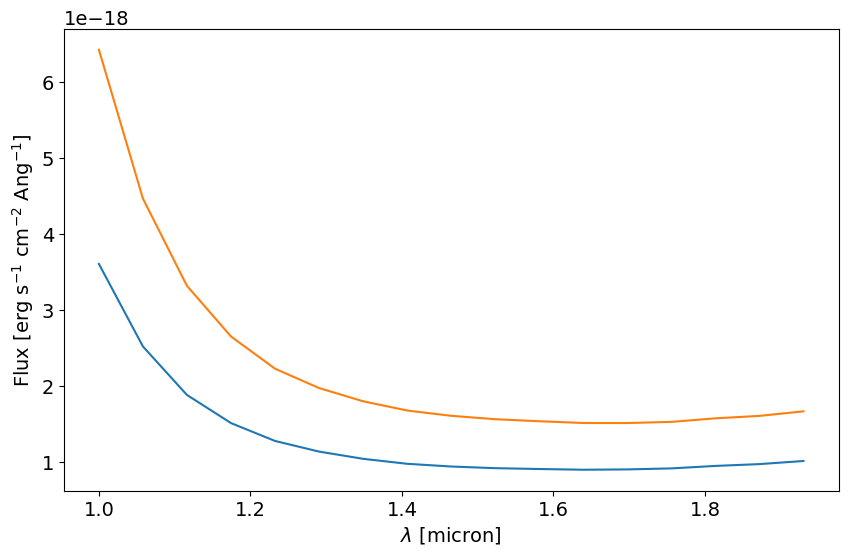

In [18]:
print(os.getcwd())
spcontetc_1n = Table.read("etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

#|  um  | arcsec |      |exp per Jy|per pix |per resl|1e4 km/s|
fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1)  
    #p.plot(spcontetc_8n['col1'],f8) 

    

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
    
plt.show()

Roughly estimated from spcontetc (>1.4 micron):

<span style="color:red">5 sigma limit = 1.75e-18 erg/s/cm^2/Ang</span>

<span style="color:red">1 sigma limit = 1.00e-18 erg/s/cm^2/Ang</span>


## Simple SN calculations based on the pzcaletc
[top](#Table-of-Contents)

/Users/gwalth/data/Roman/grizli/sims
 col1      col2        col3    ...    col10       col11       col12   
------ ----------- ----------- ... ----------- ----------- -----------
   1.0 2.71013e-19 3.55783e-19 ... 1.52512e-18 1.70082e-18 1.87693e-18
1.0332 2.29307e-19 3.00404e-19 ... 1.28054e-18 1.42783e-18 1.57547e-18
1.0664 1.95075e-19  2.5503e-19 ...  1.0811e-18 1.20524e-18  1.3297e-18
1.0996  1.7056e-19 2.22525e-19 ... 9.38094e-19 1.04565e-18 1.15347e-18
1.1329 1.53269e-19 1.99562e-19 ... 8.36668e-19  9.3244e-19 1.02845e-18
1.1661 1.40447e-19 1.82501e-19 ...  7.6096e-19 8.47925e-19 9.35111e-19
1.1993 1.30661e-19 1.69451e-19 ... 7.02705e-19 7.82881e-19 8.63265e-19
   ...         ...         ... ...         ...         ...         ...
1.7307 1.33815e-19 1.68921e-19 ... 6.44427e-19 7.16022e-19 7.87834e-19
1.7639 1.38904e-19 1.75097e-19 ... 6.64681e-19 7.38401e-19 8.12348e-19
1.7971 1.45273e-19 1.82872e-19 ... 6.90779e-19 7.67264e-19 8.43986e-19
1.8304 1.51233e-19 1.90114e-19 ... 7.146

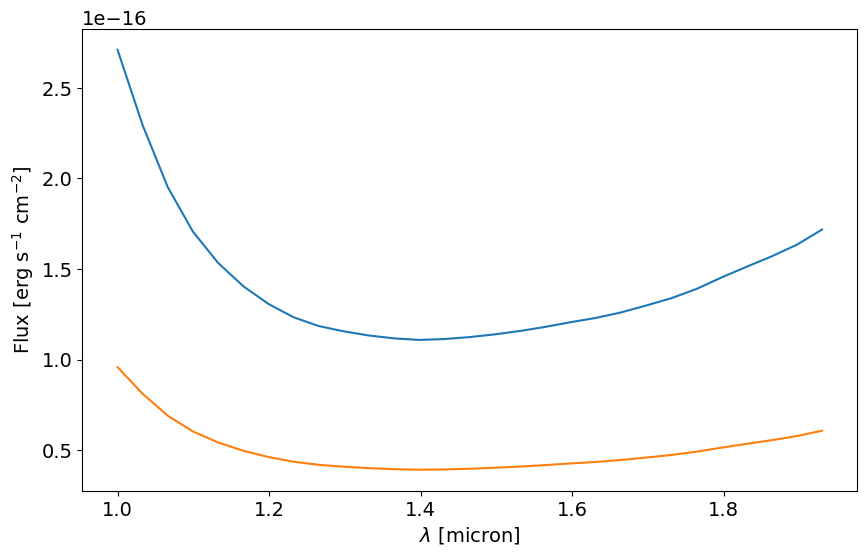

In [19]:
print(os.getcwd())
pzcaletc_1n = Table.read("etc/pzcaletc_1n.dat",format="ascii")
pzcaletc_8n = Table.read("etc/pzcaletc_8n.dat",format="ascii")
print(pzcaletc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(2,13):
for n in range(2,3):
    #p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]) # W/m^2
    p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]*1000.) # erg/s/cm^2
    p.plot(pzcaletc_8n['col1'],pzcaletc_8n['col%i' % (n)]*1000.) # erg/s/cm^2

    
#p.legend(fontsize=14)
#p.set_xlim(w1-0.05, w2+0.05)
#p.set_ylim(-1e-21,3e-20)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
    
plt.show()

## Simple SN calculations based on the apttables2021
[top](#Table-of-Contents)

/Users/gwalth/data/Roman/grizli/sims


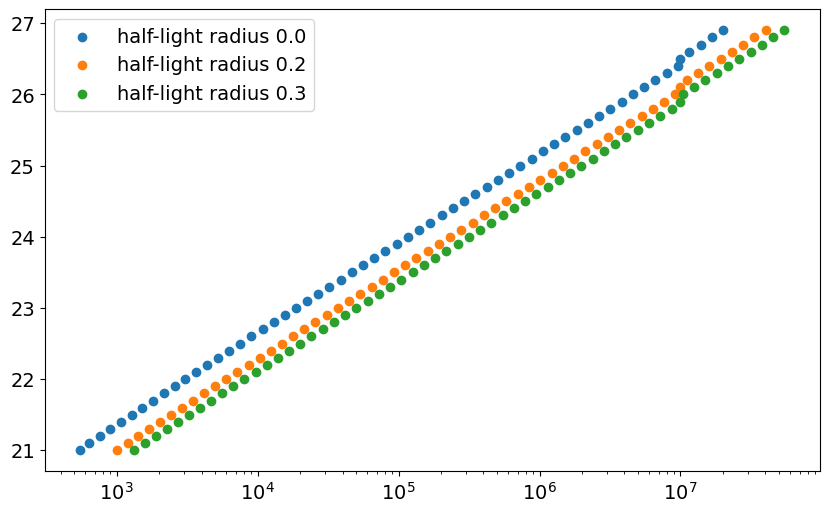

In [20]:
print(os.getcwd())
apt_rad0_0_zod1_2 = Table.read("apttables2021/grism/spec_half-light-rad0.0_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_2_zod1_2 = Table.read("apttables2021/grism/spec_half-light-rad0.2_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_3_zod1_2 = Table.read("apttables2021/grism/spec_half-light-rad0.3_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00']

#for w in wlist:
#    p.plot(apt_rad0_0_zod1_2[w],apt_rad0_0_zod1_2['AB'],label=w) 

p.scatter(apt_rad0_0_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.0')
p.scatter(apt_rad0_2_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.2')
p.scatter(apt_rad0_3_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.3')
    
p.legend(fontsize=14)
p.set_xscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
    
plt.show()

1.05
[16.9065836   1.27383247]
20.063862085214456

1.20
[17.18572913  1.27166514]
20.3376357493578

1.40
[17.07030217  1.27266754]
20.224693289505403

1.60
[16.71749973  1.27527391]
19.878350918078727

1.80
[16.27650476  1.27830027]
19.44485697276647

2.00
[16.03502399  1.27968244]
19.20680200026952



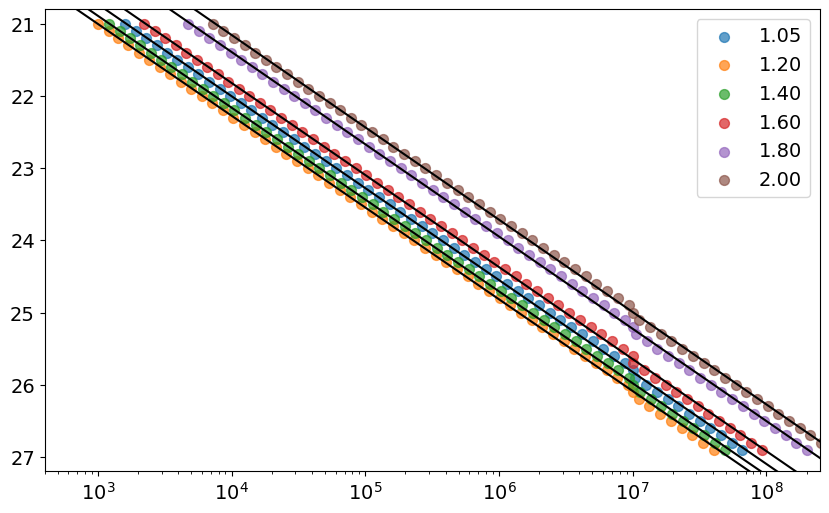

In [21]:
##############
# My crude ETC
# based on 
# https://roman.gsfc.nasa.gov/science/apttables2021/table-grism.html
##############

# notes:
# might need a fit cutoff to t = 1e7 

from scipy.optimize import leastsq

t = 301.

param = [1,0]
err = 1.0

# y = ax + b
line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00'] # microns

mag_ab_5sig = []

fig = plt.figure()
p = fig.add_subplot(111)

#x = np.log10(apt_rad0_0_zod1_2['1.20'])
y = apt_rad0_2_zod1_2['AB']
for w in wlist:
    print(w)
    x = np.log10(apt_rad0_2_zod1_2[w])

    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])

    mag_ab = line_fn(sol[0],np.log10(t))
    print(mag_ab)
    mag_ab_5sig.append(mag_ab)
    print()

    logt = np.arange(2.0,8.6,0.1)
    mag = line_fn(sol[0],logt)
    

    p.plot(10**logt,mag,c="k")
    p.scatter(10**x,y,label=w,s=50,alpha=0.7)
    
p.legend(fontsize=14)
p.set_xscale("log")

p.set_xlim(400,2.5e8)
p.set_ylim(20.8,27.2)

p.invert_yaxis()
plt.show()

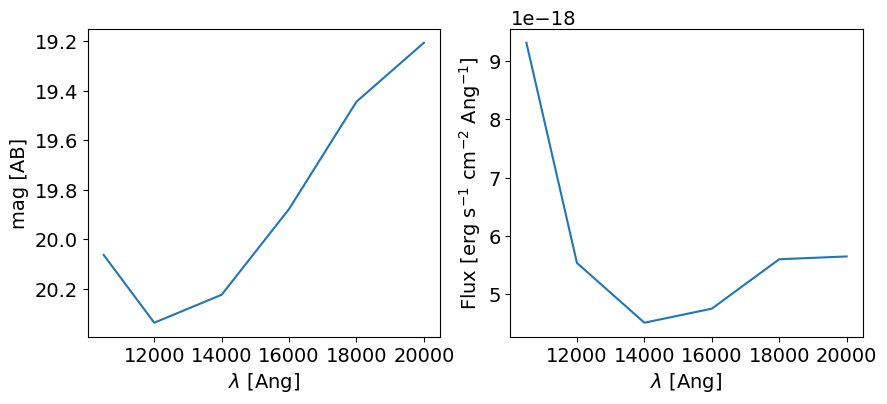

In [22]:
fig = plt.figure(figsize=(10,4))
p1 = fig.add_subplot(121)

warr = 1e4*np.array([float(w0) for w0 in wlist]) # Angstroms


mag_ab_5sig = np.array(mag_ab_5sig)

p1.plot(warr,mag_ab_5sig)
p1.set_xlabel(r'$\lambda$ [Ang]')
p1.set_ylabel(r'mag [AB]')
p1.invert_yaxis()


#p.set_xlim(0,2000)
#p.set_ylim(20,22)
p2 = fig.add_subplot(122)

#flux_5sig = [ab2flux(mag_ab_5sig[i],w0) for i,w0 in enumerate(warr)]
flux_5sig = ab2flux(mag_ab_5sig,warr) 
p2.plot(warr,flux_5sig)

p2.set_xlabel(r'$\lambda$ [Ang]')
p2.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
    
plt.show()

Comparison between spcontetc and apttables2021

/Users/gwalth/data/Roman/grizli/sims
 col1   col2   col3    col4      col5    col6    col7 
------ ------ ----- ---------- ------- ------- -------
   1.0 0.8657 117.1  5139800.0 21.1989 20.5715 21.3113
1.0581 0.8747 115.9  6604600.0 21.4656 20.8438  21.578
1.1162 0.8837 114.7  7990600.0 21.6669 21.0506 21.7792
1.1744 0.8928 113.6  9035700.0 21.7948 21.1841 21.9072
1.2325 0.9019 112.4  9767600.0 21.8738 21.2686 21.9862
1.2906 0.9111 111.3 10058000.0 21.9001 21.3004 22.0125
1.3487 0.9202 110.2 10102000.0 21.8995 21.3052 22.0118
   ...    ...   ...        ...     ...     ...     ...
1.5812 0.9574 105.9  8608500.0 21.7043 21.1315 21.8166
1.6394 0.9668 104.9  8131600.0 21.6371 21.0696 21.7495
1.6975 0.9762 103.9  7587000.0 21.5566 20.9943 21.6689
1.7556 0.9857 102.9  7023200.0 21.4675 20.9105 21.5799
1.8137 0.9952 101.9  6384100.0 21.3587 20.8069 21.4711
1.8719 1.0047 100.9  5873500.0  21.263 20.7164 21.3754
  1.93 1.0143 100.0  5326700.0 21.1518 20.6103 21.2641
Length = 17 rows


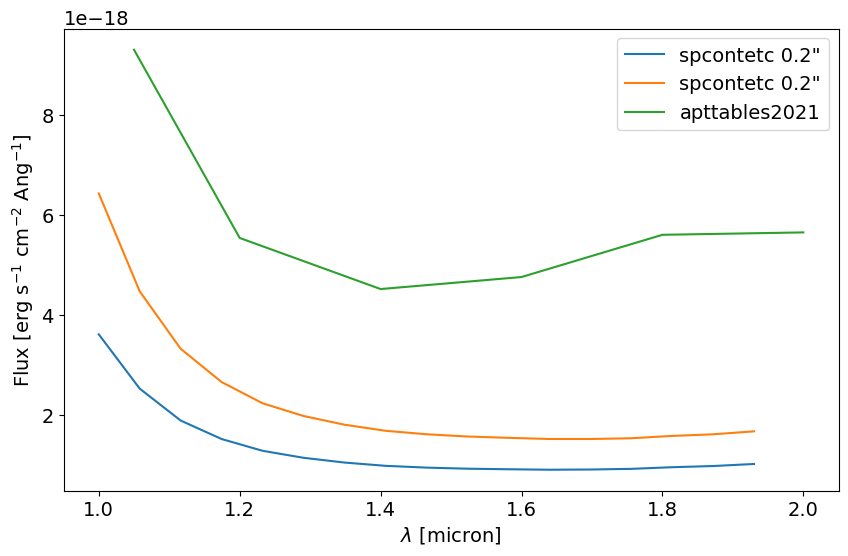

In [23]:
print(os.getcwd())
spcontetc_1n = Table.read("etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1,label='spcontetc 0.2"')  
    #p.plot(spcontetc_8n['col1'],f8) 


p.plot(warr/1e4,flux_5sig,label="apttables2021")

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
p.legend()
    
plt.show()

/Users/gwalth/data/Roman/grizli/sims
[-89.73592326  77.61208193]
[-83.6428632   70.94594587]
[-78.20641729  64.87689421]
[-73.46963447  59.36232707]
[-69.28273412  54.34397954]
[-65.72085523  49.79099686]
[-62.64147186  45.65285153]
[-60.05724564  41.89840377]
[-57.95166067  38.49699191]
[-56.24834874  35.41336941]
[-54.93318715  32.62060131]
[-54.01679502  30.09920097]
[-53.34708151  27.81057906]
[-53.00846767  25.74680748]
[-52.91265734  23.88085463]
[-52.97789776  22.18950959]
[-53.16897768  20.65338192]
[-53.48210357  19.26091405]
[-53.73410632  17.98106236]
[-53.9253553   16.80236472]
[-53.98302069  15.70915605]
[-53.81022041  14.6822372 ]
[-53.36483199  13.70985933]
[-52.56235365  12.77654852]
[-51.44862146  11.88220921]
[-49.9025894   11.00754667]
[-47.98663786  10.15628615]
[-45.71173246   9.32432037]
[-43.14690747   8.51575659]
[-40.24825771   7.72247578]
[-37.22931989   6.96405922]
[-34.07105941   6.2363996 ]
[-30.91143484   5.5511502 ]
[-27.79044612   4.90831098]
[-24.732256

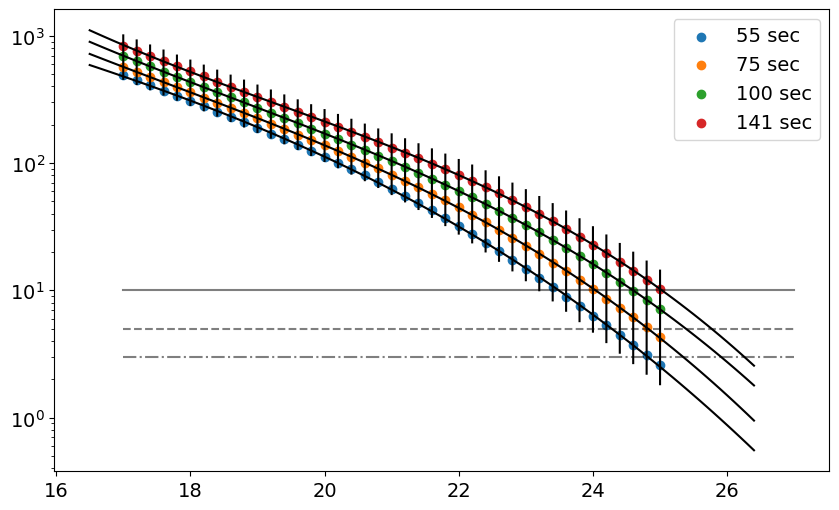

In [24]:
def poly_n(p, x):
    p = np.array(p)
    y = np.zeros((x.shape[0],))
    for n in np.arange(p.shape[0]):
        y += p[n]*x**n
    return y

def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    print(pc)
    pc[0] -= y
    print(pc)
    return np.roots(pc)


print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))


img_table = Table()
img_table['AB'] = apt_SN_55sec_zod1_2['AB']
img_table['55'] = apt_SN_55sec_zod1_2['F158']
img_table['75'] = apt_SN_75sec_zod1_2['F158']
img_table['100'] = apt_SN_100sec_zod1_2['F158']


#print(img_table)

t = 141

# SNR ~ t^(0.5)
# time
x = np.sqrt(np.array([55.,75.,100.]))
param = [1, 0]
err = 1.0

line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

fig = plt.figure()
p = fig.add_subplot(111)

SN = [] # at t

###################
# fit for SNR and t
###################
for i,y in enumerate(img_table['55','75','100']):

    # SNR
    y = np.array(list(y))
    
    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])
    
    t0 = np.arange(50,200,0.1)
    snr = line_fn(sol[0],np.sqrt(t0))
    
    mag = np.ones(snr.shape)*img_table['AB'][i]

    p.plot(mag,snr,c="k")
    
    SN.append(line_fn(sol[0],np.sqrt(t)))

img_table['141'] = SN



param = [1,1,1,1]
# mag
x = img_table['AB']
#print(x)
err = np.ones(x.shape)
#err[:5] = 0.01
#err[-5:] = 0.01

err_fn2 = lambda p: (poly_n(p,x) - y)/err
#####################
# fit for SNR and mag
#####################

dict = {}

for i,t0 in enumerate(['55','75','100','141']):
    
    # SNR
    y = 2.5*np.log10(img_table[t0])
    
    sol = leastsq(err_fn2,param,full_output=1)
    print(sol[0])
    
    mag = np.arange(16.5,26.5,0.1)
    snr = 10**(0.4*poly_n(sol[0],mag))
    
    p.plot(mag,snr,c="k")
    print(len(sol[0]))
    
    dict['sol%s' % t0] = sol[0]

#################
# solving for s/n
#################
print(dict)
sol0 = dict['sol141']
print(solve_for_y(sol0,2.5*np.log10(10.0)))


p.scatter(img_table['AB'],img_table['55'],label='55 sec')
p.scatter(img_table['AB'],img_table['75'],label='75 sec')
p.scatter(img_table['AB'],img_table['100'],label='100 sec')
p.scatter(img_table['AB'],SN,label='141 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

/Users/gwalth/data/Roman/grizli/sims


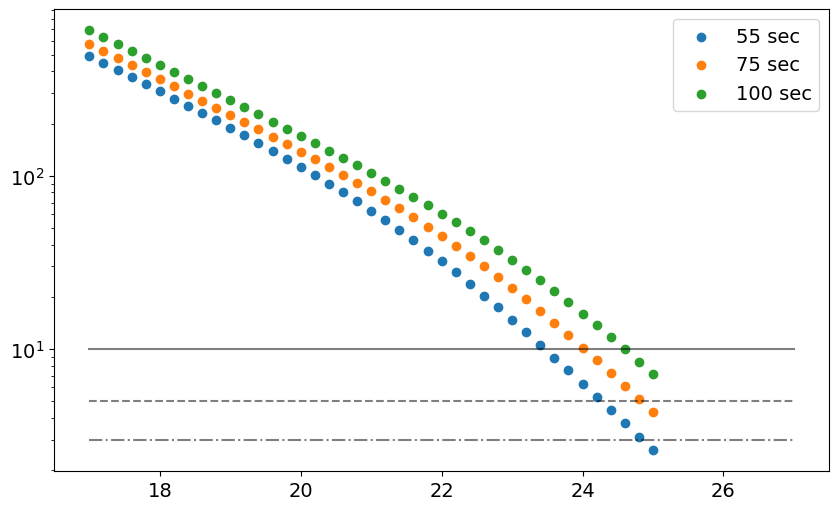

In [25]:
print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

flist = ['F062','F087','F106','F129','F158','F184','F146','F213']

#for f in flist:
#    p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2[f],label=f) 
    #p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2[f],label=f)
    #p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2[f],label=f) 

p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2['F158'],label='55 sec')
p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2['F158'],label='75 sec')
p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2['F158'],label='100 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

## Roman Sensitivity Function

[top](#Table-of-Contents)

In [ ]:
print(os.getcwd())
print(HOME_PATH)
#os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

### Gabe's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/grizli/CONF/Roman.G150.v1.6.sens.fits' # Gabe's
sens_cat1 = Table.read(sens_file)
print(sens_cat1.colnames)

### Anahita's Roman sensitivity function

In [ ]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

In [ ]:
fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.errorbar(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],yerr=sens_cat1['ERROR'])
#p1.errorbar(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],yerr=sens_cat2['ERROR'])
p1.plot(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],label="Pandeia")
p1.plot(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],label="Anahita's")
#p1.plot(pzcaletc_1n['col1']*1e4,1./(pzcaletc_1n['col%i' % (n)]*1000.)) # erg/s/cm^2
#p1.plot(pzcaletc_8n['col1']*1e4,1./(pzcaletc_8n['col%i' % (n)]*1000.)) # erg/s/cm^2
p1.set_xlim(8750,20750)
p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
p1.legend()

## 1D Spectral Extraction
[top](#Table-of-Contents)

In [ ]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(6,18))
p1 = fig.add_subplot(311)
p2 = fig.add_subplot(312)
p3 = fig.add_subplot(313)
for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    # normalize to the magnitude in the direct image
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    
    
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    #

    
    # Method 1
    scale = f_scale/np.nansum(f)
    f = f * scale
    e = e * scale
    # Method 2
    #f = (f/np.nanmedian(f)) * f_scale
    # Method 3
    #skysub = f - np.nanmedian(f)
    #f = (skysub/np.nansum(skysub)) * f_scale
    
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    
    
    percent = [1,25,50,75,95,99,99.9]
    for per in percent:
        print("P(%s) = %.2e" % (per,np.nanpercentile(f, per)))
    print()
        
    N = len(f)
        
    print("Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N")
    
    #chunks = 50. # depends on the width of the line?
    chunks = 70.
    for chunk in np.arange(chunks):
        #print("Chunk = %i" % (chunk+1))
        f_sect = f[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        e_sect = e[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect = w[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect0 = w_sect[0]/1.e4
        w_sect1 = w_sect[-1]/1.e4
        
        print("%3i  %.3f  %.3f  %.2e  %.2e  %.2e  %.2e  %.2e  %.2e  %6.1f" % (chunk+1, w_sect0, w_sect1, np.nansum(f_sect), 
              np.nanmean(f_sect), np.nanmedian(f_sect), np.nanstd(f_sect), np.nanmin(f_sect), 
              np.nanmax(f_sect), np.nansum(f_sect)/np.sqrt(np.nansum(e_sect**2))))
        #print()
        
        
    #print("S/N =",np.nanmax(f)/np.nanstd(f))
    
    m_noi = np.nanmean(e)
    S_N = f/m_noi
    
    
    # plot spectrum
    p1.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    p1.plot([w[0]/1e4,w[-1]/1e4],[m_noi,m_noi], c="g")

    # plot line
    p2.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p2.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    #print(f)
    
    # S/N of line
    p3.plot(w/1.e4, S_N, c="b") # linestyle='steps-mid')
    
    # Line flux and S/N
    print()
    w1 = 1.24
    w2 = 1.26
    #w1 = 1.36
    #w2 = 1.37
    #w1 = 1.48
    #w2 = 1.52
    i1 = np.argmin(np.abs(w/1.e4-w1))
    i2 = np.argmin(np.abs(w/1.e4-w2))
    print(i1,i2)
    
    win = w2 - w1
    i0 = np.argmin(np.abs(w/1.e4-(w1-win)))
    i3 = np.argmin(np.abs(w/1.e4-(w2+win)))
    print(i0,i3)
    print()
    

    dw = w[1] - w[0]
    print(dw)
    
    
    line_flux = np.sum(f[i0:i1])*dw
    line_error = np.sqrt(np.sum((e[i0:i1]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        
    
    line_flux = np.sum(f[i1:i2])*dw
    line_error = np.sqrt(np.sum((e[i1:i2]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    
    
    print(integrate.trapz(f[i1:i2],w[i1:i2]))
    
    print()
    
    line_flux = np.sum(f[i2:i3])*dw
    line_error = np.sqrt(np.sum((e[i2:i3]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        

    
    #y0 = np.nanmin(f)
    #y1 = np.nanmax(f)
    #print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    print()
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

#p.legend(fontsize=14)
p2.set_xlim(w1-0.05, w2+0.05)
p2.set_ylim(-1e-21,3e-20)
#p2.set_ylim(-1e-21,1e-21)
p2.set_xlabel(r'$\lambda$ [micron]')
p2.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

p3.set_xlim(w1-0.05, w2+0.05)
p3.set_ylim(-20,120.)
p3.set_xlabel(r'$\lambda$ [micron]')
p3.set_ylabel(r'S/N')

In [ ]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R1 = interpolate.interp1d(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'])
w10,w11 = sens_cat1['WAVELENGTH'][0],sens_cat1['WAVELENGTH'][-1]

R2 = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w20,w21 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

fig = plt.figure()
p1 = fig.add_subplot(111)

for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    print(w)
    
    # Method 4
    
    i10 = np.argmin(np.abs(w-w10))
    i11 = np.argmin(np.abs(w-w11))
    
    i20 = np.argmin(np.abs(w-w10))
    i21 = np.argmin(np.abs(w-w11))
    
    w1 = w[i10:i11]
    f1 = f[i10:i11]
    e1 = e[i10:i11]
    
    w2 = w[i20:i21]
    f2 = f[i20:i21]
    e2 = e[i20:i21]
    
    response1 = [R1(w_el) for w_el in w1]
    
    response2 = [R2(w_el) for w_el in w2]
    
    flux1 = f1/response1
    noise1 = e1/response1
    
    flux2 = f2/response2
    noise2 = e2/response2
    
    
    # plot spectrum
    p1.plot(w1/1.e4, flux1, c="k") # linestyle='steps-mid')
    #p1.plot(w1/1.e4, noise1, c="r") # linestyle='steps-mid')
    p1.plot(w2/1.e4, flux2, c="g") # linestyle='steps-mid')
    #p1.plot(w2/1.e4, noise2, c="r") # linestyle='steps-mid')

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')



In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#primer_number=2118 # old
primer_number=1571 

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (primer_number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (primer_number)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

In [ ]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

#fwhm = 325 # km/s
fwhm = 650 # km/s

# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
t0 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
t1 = grizli.utils.load_templates(fwhm=fwhm, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)


#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

In [ ]:
print(fit.keys())

## Velocity resolution
[top](#Table-of-Contents)

In [ ]:
# https://wfirst.ipac.caltech.edu/sims/Param_db.html#wfi_grism
# R = 461*wav # wav in microns (2pix)

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

# u = (z - z0)*c/(1+z0)
# u = dz*c/(1+z0)
# dz = u(1+z0)/c
# dz = delta_wav/wav * (1+z0)


u = lambda wav: c/(461*wav)

winc = 0.25
w = np.arange(1.0,2.0+winc,winc)
for w0 in w:
    print("v = %.2f km/s (%.2f micron)" % (u(w0),w0))

print()   
for w0 in w:
    print("R = %.2f (%.2f micron)" % (461*w0,w0))

print()
z = 0.
print("z = %.2f" % (z))
for w0 in w:
    print("dz = %.6f (%.2f micron)" % (u(w0)*(1+z)/c,w0))

    
# R = wav/delta_wav
# R = 461*wav # microns
# 1/delta_wav = 461
# delta_wav = 1/461. 
print()
print("delta_wav = %.7f microns" % (1/461.))
print("delta_wav = %.3f Angstroms" % (1/461.*10000.))




In [ ]:
# dz = delta_wav/wav * (1+z0)

dz = 10/12400.* (1+0.88615)
print(dz)

## Fit redshift to source
[top](#Table-of-Contents)

In [ ]:
fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

## Display Redshift Fit
[top](#Table-of-Contents)

In [ ]:
display_grizli(root, id, w0=0.8, w1=2.0, labels=1)

## Compare to primer

In [ ]:
print(root,id)

# Primer redshift
filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
z_true = primer["REDSHIFT"][filt]
print("z_true = %.6f" % (z_true))


# Redshift fit to the spectrum
full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
head = full_hdu[0].header
z_fit = head['REDSHIFT']
print("z_fit  = %.6f" % (z_fit))

dz = z_true - z_fit
print("dz     = %.6f" % (dz))

In [ ]:
#print(primer)
print(primer.keys())
modspec_number = 8127
#print(primer_number)
#print(primer[modspec_number-1])

filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
print(primer[filt])
print(primer["REDSHIFT"][filt])

filt = primer["SPECTEMP"] == modspec_number # MODSPEC NUMBER
print(primer[filt])

## Parallel Tests
[top](#Table-of-Contents)

In [ ]:
import multiprocessing as mp
import time

import numpy as np
#from time import time

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
mp.cpu_count()

In [ ]:
t0 = time.time()
results = [howmany_within_range(row, 4, 8) for row in data]
t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

In [ ]:
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

## Parallel Redshift Fitting Tests
[top](#Table-of-Contents)

In [ ]:

#def fit_redshift_parallel(id, grismflt, temp0, temp1, fwhm, root):
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        
    
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#for id in phot['NUMBER'][:3]:

# This breaks if there is a magnitude cut!!!
#Narr = phot['NUMBER']

#t0 = time.time()
Narr = phot['NUMBER'][:5]
#[fit_redshift_parallel(id, Roman, temp0, temp1, fwhm, root) for id in Narr]
#t1 = time.time()
#print(t1-t0,"seconds")


## version 1 
#t0 = time.time()
## Step 1: Init multiprocessing.Pool()
#pool = mp.Pool(mp.cpu_count())

## Step 2: `pool.apply` the `fit_redshift_parallel()`
##[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

#[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

## Step 3: Don't forget to close
#pool.close()
#t1 = time.time()
#print(t1-t0,"seconds")


# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        

In [ ]:
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

In [ ]:
t0 = time.time()
# This breaks if there is a magnitude cut!!!
Narr = phot['NUMBER'][:40]
[fit_redshift_parallel(id, fwhm, root) for id in Narr]
t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
Narr = phot['NUMBER'][:40]

# version 1 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `fit_redshift_parallel()`
#[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

# Step 3: Don't forget to close
pool.close()
t1 = time.time()
print(t1-t0,"seconds")



In [ ]:
print(results)

In [ ]:
Narr = phot['NUMBER'][:40]

# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


## Coordinates check
[top](#Table-of-Contents)

In [ ]:
fig = plt.figure(figsize=[10,10])

mag_limit = 25

filt_pri = primer['MAG_F1600W'] < mag_limit
filt_sex = phot['MAG_AUTO'] < mag_limit

ax = fig.add_subplot(111)
ax.scatter(primer['RA'][filt_pri], primer['DEC'][filt_pri], s=20,
               edgecolor='green', facecolor='none', alpha=0.8, label="Primer")
ax.scatter(phot['X_WORLD'][filt_sex], phot['Y_WORLD'][filt_sex], s=100,
               edgecolor='orange', facecolor='none', alpha=0.7, label="SExtractor")

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.invert_xaxis()

ax.legend(loc=1)

<span style="color:red">
Different sims may have different WCS centers!
</span>
Use this test as a way to check the correct center was used.


aXeSIM conf | hdf5
:----------:|:---:
Roman.G150.wcs_v1.RN0.conf | galacticus_ATLAS_1deg2_subsample.hdf5  
Roman.G150.wcs_v2.RN0.conf | galacticus_ForGreg.hdf5

## SED check

[top](#Table-of-Contents)

In [ ]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")

p1.set_xlabel("Wavelength [Ang]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [ ]:
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
AXE_PATH = "/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep/"

axe_image = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_images.fits"
axe_spec = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_spectra.fits"

In [ ]:
f = AXE_PATH + axe_spec
pf = pyfits.open(f)
N = len(pf)

#number = 2118 # old
number = 1571

for i in np.arange(N)+1:
    
    head = pf[i].header
    
    specname = head['SPECNAME']
    extname = head['EXTNAME']
    mag_ab = head['MAG_AB']
    
    number_found = int(specname.split("_")[-1])
    if number == number_found:
        print(i,number_found)
    
    # SPECNAME= 'ATLAS_1deg_spec_029260' / Name of spectrum 

    #tab = pf[ext].data
    #flux = tab["flux"]
    #wav = tab["wav_nm"]

In [ ]:
f = AXE_PATH + axe_spec
#f = axe_spec
#ext = 4468 # old
ext = 8127
pf = pyfits.open(f)
print(len(pf))

#print(key)

tab = pf[ext].data

flux = tab["flux"]
wav = tab["wav_nm"]


delta_wav = 1/461. # microns
delta_wav *= 1000. # nm


################################################
# convolve with the resolution of the instrument
################################################
# from iris_snr_sim (essentially from Tuan Do)

delt = 2.0*(delta_wav)/(wav[1]-wav[0])


stddev = delt/2*sqrt(2*log(2))
psf_func = models.Gaussian1D(amplitude=1.0, stddev=stddev)
x = np.arange(4*int(delt)+1)-2*int(delt)
psf = psf_func(x)
psf /= psf.sum() # normalize

new_flux = np.convolve(flux, psf,mode='same')


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(wav,flux,label="aXeSIM spectra",c="r",alpha=0.5)
p1.plot(wav,new_flux,label="Convolved spectra",c="g",alpha=0.8)
# [nm] [erg/s/cm^2/Ang]

#######################
#######################
#######################

# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571 # new

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

p1.plot(specdata["wave"]/10.,specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]

######################
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w0,w1 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
#print(w)
    
# Method 4

i0 = np.argmin(np.abs(w-w0))
i1 = np.argmin(np.abs(w-w1))

w = w[i0:i1]
f = f[i0:i1]
e = e[i0:i1]
    
response = [R(w_el) for w_el in w]
    
flux2 = f/response
noise2 = e/response
    
# plot spectrum
p1.plot(w/10., flux2, c="orange", label="extracted spectra") # linestyle='steps-mid')
# factor of 10 off, could be WAV_AB being wrong (i.e. 1600 instead of 160)

p1.set_xlim(875.0,2075.0)
#p1.set_ylim(1e-15,1e-21)
p1.set_yscale("log")
p1.set_xlabel("Wavelength [nm]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual

p1.legend(loc=1)



pf[ext].header

In [ ]:
f = AXE_PATH + axe_image

ext = 3
pf = pyfits.open(f)
print(len(pf))
pf[ext].header

#tab = pf[ext].data

#fig = plt.figure()
#p1 = fig.add_subplot(111)
#p1.plot(tab["wav_nm"],tab["flux"],label="Input spectra")
## [Ang] [erg/s/cm^2/Ang]
#p1.set_xlim(875.0,2075.0)
#p1.set_yscale("log")
##p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
##p1.legend()